# MASTERTHEISES - BANTHE - Independent work / thesis in Business Analytics


## Step: 1 Install and read packages + create local database

OMSX version 1.2.2 is installed for this code. Make sure you don´t have a newer or older version. 

### 1.1 Install third-party packages

In [1]:
%pip install pandas numpy matplotlib requests tqdm scipy scikit-learn pulp \
            geopandas shapely folium branca osmnx networkx



[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### 1.2 Import packages:

In [2]:
# === Standard libraries ===
import os
import time
import re
import csv
import pickle
import shutil
import sqlite3
from math import ceil, log
from datetime import datetime
from itertools import product
import xml.etree.ElementTree as ET

# === Third-party libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from tqdm import tqdm
from scipy.optimize import minimize
from scipy.stats import weibull_min, lognorm, gamma
from sklearn.cluster import KMeans
import pulp

# === GIS and mapping libraries ===
import geopandas as gpd
from shapely.geometry import MultiPoint, Point, Polygon
import folium
from branca.colormap import LinearColormap
import osmnx as ox
import networkx as nx

# === Parallel processing ===
from concurrent.futures import ThreadPoolExecutor, as_completed


### 1.3 Create a local database

In [3]:
# === Settings ===
db_dir = "database"
db_name = "BANTHE.db"
db_path = os.path.join(db_dir, db_name)

# === Ensure directory exists ===
os.makedirs(db_dir, exist_ok=True)

# === Connect to database ===
conn = sqlite3.connect(db_path)
cursor = conn.cursor()
print(f"✅ Connected to {db_path}")

# === Define base tables and schemas ===
base_tables = {
    "final_data_for_optimization": {
        "combination_id": "INTEGER",
        "start_cluster_id": "INTEGER",
        "end_cluster_id": "INTEGER",
        "start_quay_id": "INTEGER",
        "start_route_id": "INTEGER",
        "start_distance_km": "REAL",
        "end_quay_id": "INTEGER",
        "end_route_id": "INTEGER",
        "end_distance_km": "REAL",
        "boat_distance_km": "REAL",
        "emission_start": "REAL",
        "emission_end": "REAL",
        "emission_total_one_trip": "REAL",
        "emission_total": "REAL",
        "travel_time_hr_start": "REAL",
        "travel_time_hr_end": "REAL",
        "boat_travel_time_hr": "REAL",
        "total_travel_time": "REAL",
        "only_bus_route": "BLOB",
        "only_bus_distance": "REAL",
        "only_bus_emission": "REAL",
        "only_bus_time": "REAL",
        "trips_needed": "INTEGER",
        "total_emission_bus": "REAL",
        "total_num_passengers": "INTEGER"
    },
    "optimized_routes": {
        "start_cluster_id": "INTEGER",
        "end_cluster_id": "INTEGER",
        "combination_id": "REAL",
        "start_quay_id": "REAL",
        "start_route_id": "REAL",
        "start_distance_km": "REAL",
        "end_quay_id": "REAL",
        "end_route_id": "REAL",
        "end_distance_km": "REAL",
        "boat_distance_km": "REAL",
        "emission_start": "REAL",
        "emission_end": "REAL",
        "emission_total_one_trip": "REAL",
        "emission_total": "REAL",
        "travel_time_hr_start": "REAL",
        "travel_time_hr_end": "REAL",
        "boat_travel_time_hr": "REAL",
        "total_travel_time": "REAL",
        "only_bus_route": "TEXT",
        "only_bus_distance": "REAL",
        "only_bus_emission": "REAL",
        "only_bus_time": "REAL",
        "trips_needed": "REAL",
        "total_emission_bus": "REAL",
        "total_num_passengers": "REAL",
        "total_emission": "REAL",
        "total_time": "REAL",
        "total_travel_time_bus": "REAL"
    }
}

# === Define all tables including inheritance references ===
tables = {
    "Skyss_data_weekdays_2023": {
        "StopID": "TEXT",
        "StopName": "TEXT",
        "Line": "TEXT",
        "Direction": "TEXT",
        "Boarding": "INTEGER",
        "Alighting": "INTEGER",
        "Year": "INTEGER",
        "Weekday": "TEXT",
        "Date": "TEXT"
    },
    "clusters": {
        "cluster_id": "INTEGER PRIMARY KEY",
        "latitude": "REAL",
        "longitude": "REAL",
        "direct_roads_to_all_clusters": "INTEGER"
    },
    "quays": {
        "quay_id": "INTEGER PRIMARY KEY",
        "latitude": "REAL",
        "longitude": "REAL",
        "is_on_island": "INTEGER"
    },
    "cluster_distances": {
        "start_cluster_id": "INTEGER",
        "end_cluster_id": "INTEGER",
        "total_distance_km": "REAL",
        "total_travel_time": "REAL",
        "travel_time_to_cluster": "REAL",
        "travel_time_to_quay": "REAL",
        "travel_time_boat": "REAL",
        "distance_km_to_cluster": "REAL",
        "distance_km_to_quay": "REAL",
        "direct_roads_to_all_clusters": "INTEGER",
        "start_quay_id": "INTEGER",
        "end_quay_id": "INTEGER",
        "boat_route_id": "BLOB",
        "boat_route": "BLOB",
        "route": "BLOB",
        "route_entur": "BLOB",
        "route_entur_to_quay": "BLOB",
        "PRIMARY KEY": "(start_cluster_id, end_cluster_id)"
    },
    "cluster_77_quay_13": {
        "start_quay_id": "INTEGER PRIMARY KEY",
        "start_cluster_id": "INTEGER",
        "distance_km_to_quay": "REAL",
        "travel_time_to_quay": "REAL",
        "route_entur_to_quay": "BLOB"
    },
    "bus_routes_with_emission": {
        "start_cluster_id": "INTEGER",
        "end_cluster_id": "INTEGER",
        "total_distance_km": "REAL",
        "total_travel_time": "REAL",
        "emission_kg": "REAL",
        "route": "BLOB",
        "route_entur": "BLOB"
    },
    "cluster_to_quay_routes": {
        "bus_quay_route_id": "INTEGER PRIMARY KEY AUTOINCREMENT",
        "start_cluster_id": "INTEGER",
        "start_cluster_lat": "REAL",
        "start_cluster_lon": "REAL",
        "start_quay_id": "INTEGER",
        "start_quay_lat": "REAL",
        "start_quay_lon": "REAL",
        "distance_km": "REAL",
        "travel_time_hr": "REAL",
        "route": "BLOB",
        "route_entur": "BLOB"
    },
    "travel_matrix": {
        "StartCluster": "INTEGER",
        "EndCluster": "INTEGER",
        "Passengers": "INTEGER"
    },
    "transport_emission": {
        "transport_type": "TEXT",
        "emission_per_km": "REAL"
    },
    "final_data_for_optimization": base_tables["final_data_for_optimization"],
    "final_data_for_optimization_0": base_tables["final_data_for_optimization"],
    "final_data_for_optimization_100": base_tables["final_data_for_optimization"],
    "final_data_for_optimization_120": base_tables["final_data_for_optimization"],
    "final_data_for_optimization_140": base_tables["final_data_for_optimization"],
    "final_data_for_optimization_150": base_tables["final_data_for_optimization"],
    "optimized_routes": base_tables["optimized_routes"],
    "optimized_routes_0": base_tables["optimized_routes"],
    "optimized_routes_100": base_tables["optimized_routes"],
    "optimized_routes_120": base_tables["optimized_routes"],
    "optimized_routes_140": base_tables["optimized_routes"],
    "optimized_routes_150": base_tables["optimized_routes"]
}


# === Create or update tables ===
for table_name, columns in tables.items():
    # Step 1: Create minimal table if it does not exist
    if "PRIMARY KEY" in columns:
        # Special case: composite primary key
        cols = [f"{col} {dtype}" for col, dtype in columns.items() if col != "PRIMARY KEY"]
        pk = columns["PRIMARY KEY"]
        sql = f"CREATE TABLE IF NOT EXISTS {table_name} ({', '.join(cols)}, PRIMARY KEY {pk});"
    else:
        cols = [f"{col} {dtype}" for col, dtype in columns.items()]
        sql = f"CREATE TABLE IF NOT EXISTS {table_name} ({', '.join(cols)});"

    cursor.execute(sql)

    # Step 2: Check for missing columns and add them
    cursor.execute(f"PRAGMA table_info({table_name})")
    existing = {row[1] for row in cursor.fetchall()}
    for col, dtype in columns.items():
        if col != "PRIMARY KEY" and col not in existing:
            cursor.execute(f"ALTER TABLE {table_name} ADD COLUMN {col} {dtype};")
            print(f"➕ Added column '{col}' to table '{table_name}'")

conn.commit()
conn.close()
print("✅ All tables created or updated successfully.")


✅ Connected to database/BANTHE.db
✅ All tables created or updated successfully.


## Step 2: Import and Filter Skyss Passenger Data (Weekdays 2023), Then Insert to SQLite


In [4]:
# === Step 2: Load, Filter and Store Skyss Weekday Data in SQLite Database ===
# This block:
# - Reads raw CSV file from Skyss containing weekday passenger data (2023 and 2024)
# - Filters rows for year 2023 only
# - Saves the filtered data to a new CSV for inspection
# - Creates (if needed) and connects to an SQLite database (BANTHE.db)
# - Inserts the filtered 2023 data into a database table named 'Skyss_data_weekdays_2023'

# === File paths ===
input_file_path = 'Input/Skyss/Passasjertall for holdeplass_ukedager_2023_2024.csv'
output_file_path = 'Output/2/Passasjertall for holdeplass_ukedager_2023.csv'
output_db_path = 'database/'
db_name = "BANTHE.db"
table_name = "Skyss_data_weekdays_2023"

# === Ensure output folder exists ===
os.makedirs(output_db_path, exist_ok=True)

# === Load CSV file ===
try:
    print(f"Reading data from {input_file_path}...")
    df = pd.read_csv(input_file_path)
    print(f"✅ CSV loaded: {len(df)} rows, {len(df.columns)} columns.")
except Exception as e:
    print(f"❌ Failed to load CSV: {e}")
    exit()

# === Filter for 2023 data ===
try:
    print("Filtering data for year 2023...")
    df_filtered_2023 = df[df['Year'] == 2023]
    print(f"✅ Filtered rows: {len(df_filtered_2023)}")
except KeyError:
    print("❌ Missing 'Year' column in CSV. Please check format.")
    exit()

# === Save filtered data to new CSV ===
try:
    print(f"Saving filtered data to {output_file_path}...")
    df_filtered_2023.to_csv(output_file_path, index=False)
    print(f"✅ Saved to: {output_file_path}")
except Exception as e:
    print(f"❌ Failed to save filtered data: {e}")
    exit()

# === Prepare database path ===
db_path = os.path.join(output_db_path, db_name)

if os.path.exists(db_path):
    print(f"Connecting to existing database at {db_path}.")
else:
    print(f"Creating new database at {db_path}.")

# === Connect to SQLite ===
try:
    conn = sqlite3.connect(db_path)
    print(f"✅ Connected to database: {db_name}")
except Exception as e:
    print(f"❌ Database connection failed: {e}")
    exit()

# === Create and insert table ===
try:
    print(f"Inserting data into table '{table_name}'...")
    df_filtered_2023.to_sql(table_name, conn, if_exists='replace', index=False)
    print(f"✅ Data inserted into table '{table_name}'.")
except Exception as e:
    print(f"❌ Failed to insert data: {e}")
finally:
    conn.close()

print(f"Done. Data available in {db_path}")


Reading data from Input/Skyss/Passasjertall for holdeplass_ukedager_2023_2024.csv...
✅ CSV loaded: 8484 rows, 12 columns.
Filtering data for year 2023...
✅ Filtered rows: 4248
Saving filtered data to Output/2/Passasjertall for holdeplass_ukedager_2023.csv...
✅ Saved to: Output/2/Passasjertall for holdeplass_ukedager_2023.csv
Connecting to existing database at database/BANTHE.db.
✅ Connected to database: BANTHE.db
Inserting data into table 'Skyss_data_weekdays_2023'...
✅ Data inserted into table 'Skyss_data_weekdays_2023'.
Done. Data available in database/BANTHE.db


## Step 3: Load Population Grid and Generate Spatial Clusters


In [5]:
# ============================================
# STEP 3: Generate Clusters from Population Grid
# - Reads GeoJSON population data from multiple municipalities
# - Applies KMeans clustering on population-weighted centroids
# - Computes convex hulls and centroids for each cluster
# - Saves cluster centroids (with IDs) to SQLite database
# - Visualizes all clusters and population grids on an interactive Folium map
# ============================================


# === 1. Define folder paths ===
data_folder_population = 'Input/Population/'
output_folder = 'Output/3/'
db_path = 'Database/BANTHE.db'

os.makedirs(output_folder, exist_ok=True)
os.makedirs(os.path.dirname(db_path), exist_ok=True)

# === 2. Define input files (population grid for each municipality) ===
geojson_files_population = [
    "v_ru250m_2023_rutenett_ALVER.geojson",
    "v_ru250m_2023_rutenett_ASKOY.geojson",
    "v_ru250m_2023_rutenett_AUSTEVOLL.geojson",
    "v_ru250m_2023_rutenett_BERGEN.geojson",
    "v_ru250m_2023_rutenett_OYGARDEN.geojson"
]

# === 3. Initialize folium map ===
m = folium.Map(location=[60.39, 5.32], zoom_start=9)

# === 4. Define colormap for population intensity ===
colormap = LinearColormap(
    colors=['#ffffcc', '#ffeda0', '#feb24c', '#fd8d3c', '#f03b20', '#bd0026', '#800026'],
    index=[1, 7, 32, 125, 313, 625, 1250],
    vmin=1,
    vmax=1250,
    caption='Population per 250m Grid (2023)'
)

# === 5. Load and visualize population data ===
gdfs_population = []
for geojson_file in geojson_files_population:
    file_path = os.path.join(data_folder_population, geojson_file)
    if not os.path.exists(file_path):
        print(f"❌ File not found: {file_path}")
        continue
    gdf = gpd.read_file(file_path)
    if gdf.crs is None:
        gdf.set_crs(epsg=4326, inplace=True)
    gdfs_population.append(gdf)

    folium.GeoJson(
        gdf,
        name=geojson_file.split('_')[3],
        style_function=lambda feature: {
            'fillColor': colormap(feature['properties'].get('pop_tot', 1)),
            'color': 'black',
            'weight': 0.5,
            'fillOpacity': 0.7,
        },
        tooltip=folium.GeoJsonTooltip(fields=["pop_tot"], aliases=["Population:"])
    ).add_to(m)

# === 6. Merge all GeoDataFrames and reproject ===
if not gdfs_population:
    raise ValueError("❌ No population GeoJSON files were successfully loaded.")
gdf_combined = gpd.GeoDataFrame(pd.concat(gdfs_population, ignore_index=True)).to_crs(epsg=3395)

# === 7. Extract centroids for clustering ===
coordinates = gdf_combined.geometry.centroid.apply(lambda point: (point.x, point.y)).tolist()
coordinates_df = pd.DataFrame(coordinates, columns=['x', 'y'])
coordinates_df['population'] = gdf_combined['pop_tot']

# === 8. Apply KMeans clustering ===
n_clusters = 130
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
coordinates_df['cluster'] = kmeans.fit_predict(coordinates_df[['x', 'y']])
gdf_combined['cluster'] = coordinates_df['cluster']

# === 9. Create convex hulls from clusters ===
convex_hulls = gdf_combined.groupby('cluster')['geometry'].apply(
    lambda x: MultiPoint([geom.centroid for geom in x]).convex_hull
)
convex_hull_gdf = gpd.GeoDataFrame(convex_hulls, geometry='geometry', crs=gdf_combined.crs).reset_index()
convex_hull_gdf['centroid'] = convex_hull_gdf.geometry.centroid

# === 10. Convert centroids to EPSG:4326 ===
convex_hull_gdf = convex_hull_gdf.to_crs(epsg=4326)
centroids = np.array([[point.x, point.y] for point in convex_hull_gdf['centroid']])
centroids_latlon = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(centroids[:, 0], centroids[:, 1], crs="EPSG:3395")
).to_crs(epsg=4326)
cluster_ids = convex_hull_gdf['cluster'].tolist()

# === 11. Save cluster centroids to SQLite ===
conn = sqlite3.connect(db_path)
try:
    conn.execute("DROP TABLE IF EXISTS clusters")
    conn.execute("""
    CREATE TABLE clusters (
        cluster_id INTEGER PRIMARY KEY,
        cluster_name TEXT,
        latitude REAL,
        longitude REAL
    )
    """)
    centroids_data = [
        {"cluster_id": cluster_id, "cluster_name": f"Cluster {cluster_id}", "latitude": row.geometry.y, "longitude": row.geometry.x}
        for cluster_id, row in zip(cluster_ids, centroids_latlon.itertuples())
    ]
    pd.DataFrame(centroids_data).to_sql('clusters', conn, if_exists='replace', index=False)
    print("✅ Centroids saved to database.")
finally:
    conn.close()

# === 12. Add convex hulls to map ===
for _, row in convex_hull_gdf.iterrows():
    folium.GeoJson(
        row['geometry'].__geo_interface__,
        style_function=lambda x: {'fillColor': 'blue', 'color': 'blue', 'weight': 1, 'fillOpacity': 0.2},
        tooltip=f"Cluster ID: {row['cluster']}"
    ).add_to(m)

# === 13. Add centroid markers to map ===
for idx, row in centroids_latlon.iterrows():
    lat, lon = row.geometry.y, row.geometry.x
    folium.Marker(
        [lat, lon],
        popup=(
            f"<b>Cluster ID:</b> {cluster_ids[idx]}<br>"
            f"<b>Latitude:</b> {lat:.6f}<br>"
            f"<b>Longitude:</b> {lon:.6f}"
        ),
        icon=folium.Icon(color="red", icon="info-sign")
    ).add_to(m)

# === 14. Display map ===
m


✅ Centroids saved to database.


### 3.1 Add Binary Flag for Clusters Without Direct Road Access

In [6]:
# === 3.1 Set Road Access Flags for Clusters ===

# Path to the database
db_path = 'Database/BANTHE.db'

# Cluster IDs without full road connections (island clusters)
clusters_with_no_direct_roads = {48, 81, 21, 83, 55, 34, 97, 127, 7, 101, 77}

# Helper function to check if a column exists in a table
def column_exists(cursor, table_name, column_name):
    cursor.execute(f"PRAGMA table_info({table_name})")
    columns = [info[1] for info in cursor.fetchall()]
    return column_name in columns

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

try:
    cursor = conn.cursor()

    # Add the column only if it doesn't already exist
    if not column_exists(cursor, 'clusters', 'direct_roads_to_all_clusters'):
        conn.execute("ALTER TABLE clusters ADD COLUMN direct_roads_to_all_clusters INTEGER DEFAULT 1")
        print("✅ Column 'direct_roads_to_all_clusters' added.")
    else:
        print("Column 'direct_roads_to_all_clusters' already exists.")

    # Update the flag to 0 for clusters without direct road access
    for cluster_id in clusters_with_no_direct_roads:
        conn.execute("""
        UPDATE clusters
        SET direct_roads_to_all_clusters = 0
        WHERE cluster_id = ?
        """, (cluster_id,))

    conn.commit()
    print("✅ 'clusters' table updated with direct road access flags.")
finally:
    conn.close()


✅ Column 'direct_roads_to_all_clusters' added.
✅ 'clusters' table updated with direct road access flags.


## Step 4: Import boat Quays and Compute Distances

### 4.1 Load boat Quay Locations

In [7]:
# ============================================
# STEP 4: Import and Register boat Quays
# - Reads quay location data from CSV file
# - Flags which quay locations are on islands
# - Stores the cleaned data in the SQLite database
# - Visualizes the quay locations on a folium map
# ============================================

# === 1. Define file paths ===
db_path = 'Database/BANTHE.db'
quay_csv_path = 'Input/Quays/Quay locations.csv'
quay_table_name = 'quays'

# === 2. Define island quay IDs manually ===
island_quays = {12, 13}

# === 3. Load quay data from CSV ===
try:
    quay_data = pd.read_csv(quay_csv_path, delimiter=';')
    quay_data['latitude'] = pd.to_numeric(quay_data['Latitude'], errors='coerce')
    quay_data['longitude'] = pd.to_numeric(quay_data['Longitude'], errors='coerce')
    quay_data['quay_id'] = pd.to_numeric(quay_data['Quay_id'], errors='coerce')
    quay_data.dropna(subset=['latitude', 'longitude'], inplace=True)
    print("✅ Quay data successfully loaded and cleaned.")
except Exception as e:
    print(f"❌ Failed to load quay data: {e}")

# === 4. Flag island quays ===
quay_data['is_on_island'] = quay_data['quay_id'].apply(lambda x: 1 if x in island_quays else 0)

# === 5. Keep relevant columns ===
quay_data = quay_data[['quay_id', 'Quay_name', 'latitude', 'longitude', 'is_on_island']]

# === 6. Write quay data to SQLite ===
try:
    conn = sqlite3.connect(db_path, timeout=10)
    with conn:
        cursor = conn.cursor()

        # Drop and recreate table
        cursor.execute(f"DROP TABLE IF EXISTS {quay_table_name};")
        cursor.execute(f"""
            CREATE TABLE {quay_table_name} (
                quay_id INTEGER PRIMARY KEY,
                quay_name TEXT,
                latitude REAL,
                longitude REAL,
                is_on_island INTEGER DEFAULT 0
            )
        """)

        # Insert in batches
        batch_size = 1000
        for batch_start in range(0, len(quay_data), batch_size):
            batch = quay_data.iloc[batch_start:batch_start + batch_size]
            cursor.executemany(f"""
                INSERT INTO {quay_table_name} (
                    quay_id, quay_name, latitude, longitude, is_on_island
                ) VALUES (
                    :quay_id, :Quay_name, :latitude, :longitude, :is_on_island
                )
            """, batch.to_dict(orient='records'))
            conn.commit()

    print(f"✅ Quay data stored in '{quay_table_name}' table.")
except sqlite3.OperationalError as e:
    print(f"❌ Database error: {e}")
finally:
    conn.close()

# === 7. Visualize quays on a map ===
if quay_data.empty:
    print("❌ No quay data to display on map.")
else:
    start_lat, start_lon = quay_data.iloc[0]["latitude"], quay_data.iloc[0]["longitude"]
    m = folium.Map(location=[start_lat, start_lon], zoom_start=10)

    for _, row in quay_data.iterrows():
        folium.Marker(
            location=[row["latitude"], row["longitude"]],
            popup=f"ID: {int(row['quay_id'])}<br>Name: {row['Quay_name']}",
            icon=folium.Icon(color="blue", icon="info-sign")
        ).add_to(m)

    print("✅ Quay map generated.")

m


✅ Quay data successfully loaded and cleaned.
✅ Quay data stored in 'quays' table.
✅ Quay map generated.


### 4.2 Calibrate Quay Distances with data from OpenSeaMap

In [8]:
# ============================================
# STEP 4.2: Calibrate Quay Distances from CSV Route Data
# - Reads route data from CSV files for each quay pair
# - Converts coordinates to decimal degrees and nautical miles to km
# - Stores encoded routes and distances in SQLite database (quay_distances)
# - Calibrates boat speed using known travel time for route 12 ➝ 14
# - Estimates travel time for all boat routes
# - Optionally visualizes routes on a folium map
# ============================================

# === 1. Define input/output paths ===
route_dir = "Input/Quays/routes/"
db_path = "Database/BANTHE.db"
table_name = "quay_distances"

# === 2. Connect to SQLite database ===
conn = sqlite3.connect(db_path, timeout=10)
cursor = conn.cursor()

# === 3. Create quay_distances table (if not exists) ===
cursor.execute(f"""
CREATE TABLE IF NOT EXISTS quay_distances (
    start_quay_id INTEGER,
    end_quay_id INTEGER,
    boat_route BLOB,
    boat_distance_km REAL,
    boat_travel_time_hr REAL,
    PRIMARY KEY (start_quay_id, end_quay_id)
)
""")
conn.commit()
print("✅ Table 'quay_distances' ready.")

# === 4. Coordinate conversion helpers ===
def convert_to_decimal(coord):
    try:
        coord = coord.replace("'", "").replace('"', "").strip()
        lat_raw, lon_raw = coord.split(" - ")
        lat_match = re.search(r"([NS])\s*(\d+)°(\d+\.\d+)", lat_raw)
        lon_match = re.search(r"([EW])\s*(\d+)°(\d+\.\d+)", lon_raw)

        if not lat_match or not lon_match:
            print(f"⚠️ Invalid coordinate format: {coord}")
            return None, None

        lat_dir, lat_deg, lat_min = lat_match.groups()
        lon_dir, lon_deg, lon_min = lon_match.groups()

        latitude = float(lat_deg) + float(lat_min) / 60
        longitude = float(lon_deg) + float(lon_min) / 60

        if lat_dir == "S":
            latitude *= -1
        if lon_dir == "W":
            longitude *= -1

        return latitude, longitude
    except Exception as e:
        print(f"⚠️ Conversion error: {coord} - {e}")
        return None, None

def convert_nm_to_km(distance_nm):
    try:
        return float(distance_nm.replace("nm", "").strip()) * 1.852
    except Exception as e:
        print(f"⚠️ Distance conversion error: {distance_nm} - {e}")
        return None

# === 5. Process route CSV files ===
csv_files = [f for f in os.listdir(route_dir) if f.endswith(".csv")]
routes = []
print(f"Found {len(csv_files)} CSV route files.")

for file in csv_files:
    file_path = os.path.join(route_dir, file)

    try:
        start_quay, end_quay = map(int, file.replace(".csv", "").split("-"))
    except ValueError:
        print(f"⚠️ Invalid file name: {file} - skipping.")
        continue

    try:
        df = pd.read_csv(file_path, delimiter=";", header=0)
    except Exception as e:
        print(f"⚠️ Failed to read {file}: {e} - skipping.")
        continue

    if not {"Course", "Distance", "Coordinate"}.issubset(df.columns):
        print(f"⚠️ Missing columns in {file} - skipping.")
        continue

    df[['Latitude', 'Longitude']] = df['Coordinate'].apply(lambda x: pd.Series(convert_to_decimal(str(x))))
    df["Distance_km"] = df["Distance"].apply(lambda x: convert_nm_to_km(str(x)))
    df.dropna(subset=["Latitude", "Longitude", "Distance_km"], inplace=True)

    if len(df) < 2:
        print(f"⚠️ Too few valid coordinates in {file} - skipping.")
        continue

    total_distance_km = df["Distance_km"].sum()
    route_points = list(zip(df["Latitude"], df["Longitude"]))

    routes.append((start_quay, end_quay, pickle.dumps(route_points), total_distance_km))
    routes.append((end_quay, start_quay, pickle.dumps(route_points), total_distance_km))

# === 6. Store routes in database (travel time is added later) ===
if routes:
    cursor.executemany(f"""
        INSERT OR REPLACE INTO {table_name} (start_quay_id, end_quay_id, boat_route, boat_distance_km)
        VALUES (?, ?, ?, ?)
    """, routes)
    conn.commit()
    print(f"✅ {len(routes)} routes stored in '{table_name}'.")
else:
    print("⚠️ No valid routes to store.")

# === 7. Estimate boat speed using route 12 ➔ 14 ===
print("Estimating boat speed based on route 12 ➔ 14...")
cursor.execute("""
SELECT boat_distance_km
FROM quay_distances
WHERE start_quay_id = 12 AND end_quay_id = 14
""")
result = cursor.fetchone()

if result:
    boat_distance_km = result[0]
    boat_distance_nm = boat_distance_km / 1.852
    travel_time_hr_known = 35 / 60
    estimated_speed_knots = boat_distance_nm / travel_time_hr_known
    print(f"✅ Estimated speed: {estimated_speed_knots:.2f} knots.")
else:
    raise RuntimeError("❌ Route 12 ➔ 14 not found for speed estimation.")

# === 8. Add travel time column if needed ===
cursor.execute("PRAGMA table_info(quay_distances);")
columns = [col[1] for col in cursor.fetchall()]
if "boat_travel_time_hr" not in columns:
    print("⚙️ Adding column 'boat_travel_time_hr' to table...")
    cursor.execute("ALTER TABLE quay_distances ADD COLUMN boat_travel_time_hr REAL;")
    conn.commit()
    print("✅ Column added.")
else:
    print("Column 'boat_travel_time_hr' already exists.")

# === 9. Calculate and update travel time for each route ===
print("Updating boat_travel_time_hr values...")
cursor.execute("SELECT start_quay_id, end_quay_id, boat_distance_km FROM quay_distances")
all_routes = cursor.fetchall()

for start_quay_id, end_quay_id, boat_distance_km in all_routes:
    if boat_distance_km is not None:
        boat_distance_nm = boat_distance_km / 1.852
        travel_time_hr = boat_distance_nm / estimated_speed_knots
        cursor.execute("""
            UPDATE quay_distances
            SET boat_travel_time_hr = ?
            WHERE start_quay_id = ? AND end_quay_id = ?
        """, (travel_time_hr, start_quay_id, end_quay_id))

conn.commit()
print("✅ All boat_travel_time_hr values updated.")
conn.close()

# === 10. Generate map (if routes exist) ===
if routes:
    print("Generating route map...")
    first_route = pickle.loads(routes[0][2])
    m = folium.Map(location=[first_route[0][0], first_route[0][1]], zoom_start=10)

    for route in routes:
        route_data = pickle.loads(route[2])
        folium.PolyLine(route_data, color="blue", weight=2.5, opacity=0.8).add_to(m)

    print("✅ Map generated.")
else:
    print("❌ No routes to display on map.")

m


✅ Table 'quay_distances' ready.
Found 91 CSV route files.
✅ 182 routes stored in 'quay_distances'.
Estimating boat speed based on route 12 ➔ 14...
✅ Estimated speed: 12.15 knots.
Column 'boat_travel_time_hr' already exists.
Updating boat_travel_time_hr values...
✅ All boat_travel_time_hr values updated.
Generating route map...
✅ Map generated.


## Step 5: Compute All Cluster-to-Cluster Travel Routes

### 5.1 Road-Based Routing for Mainland Clusters
- Uses OpenStreetMap and A* to compute driving routes between road-connected clusters.

In [9]:
# ============================================
# STEP 5.1: Compute Road-Based Cluster Distances
# - Loads clusters with mainland road access
# - Loads or builds OpenStreetMap-based road network
# - Uses A* search algorithm to compute shortest road routes between cluster pairs
# - Calculates both distance (km) and estimated travel time (hr)
# - Results are stored in the 'cluster_distances' table in SQLite
# - Caches nearest OSM nodes for improved performance on re-run
# ============================================

# === 1. Define input/output paths ===
db_path = 'Database/BANTHE.db'

# === 2. Connect to SQLite database ===
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# === 3. Validate existence of 'clusters' table ===
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='clusters';")
if not cursor.fetchone():
    raise RuntimeError("❌ Table 'clusters' does not exist.")

# === 4. Load mainland clusters with road access ===
query = """
SELECT cluster_id, latitude, longitude, direct_roads_to_all_clusters
FROM clusters
WHERE direct_roads_to_all_clusters = 1;
"""
clusters_df = pd.read_sql_query(query, conn)
print(f"Loaded {len(clusters_df)} clusters with road access.")

# === 5. Load or build OSM road network ===
graphml_path = "vestlandet_bounded_road_network.graphml"
if os.path.exists(graphml_path):
    graph = ox.load_graphml(graphml_path)
else:
    coordinates = [(4.69, 60.79), (7.12, 61.11), (5.96, 59.93), (4.65, 59.94), (4.69, 60.79)]
    bounding_polygon = Polygon(coordinates).buffer(0)
    graph = ox.graph_from_polygon(bounding_polygon, network_type="drive")
    ox.save_graphml(graph, graphml_path)

# === 6. Add speed and travel time to edges ===
graph = ox.add_edge_speeds(graph)
graph = ox.add_edge_travel_times(graph)

# === 7. Load or initialize nearest-node cache ===
cache_file = 'cache_nearest_nodes.pkl'
try:
    with open(cache_file, 'rb') as f:
        nearest_nodes_cache = pickle.load(f)
except FileNotFoundError:
    nearest_nodes_cache = {}

def find_nearest_node(lat, lon):
    coord_key = (lat, lon)
    if coord_key not in nearest_nodes_cache:
        nearest_nodes_cache[coord_key] = ox.distance.nearest_nodes(graph, X=lon, Y=lat)
    return nearest_nodes_cache[coord_key]

# === 8. Define A* heuristic function ===
def heuristic(node1, node2):
    x1, y1 = graph.nodes[node1]['x'], graph.nodes[node1]['y']
    x2, y2 = graph.nodes[node2]['x'], graph.nodes[node2]['y']
    return ox.distance.euclidean_dist_vec(y1, x1, y2, x2)

# === 9. A* path calculation function ===
def calculate_route_and_distance(start_node, end_node):
    try:
        route = nx.astar_path(graph, start_node, end_node, heuristic=heuristic, weight='length')
        total_distance_km = nx.path_weight(graph, route, weight='length') / 1000
        total_travel_time_sec = nx.path_weight(graph, route, weight='travel_time')
        total_travel_time_hr = total_travel_time_sec / 3600
        return route, total_distance_km, total_travel_time_hr
    except nx.NetworkXNoPath:
        return None, None, None

# === 10. Find nearest graph nodes for clusters ===
print("Locating nearest OSM nodes...")
clusters_df['nearest_node'] = clusters_df.apply(lambda row: find_nearest_node(row['latitude'], row['longitude']), axis=1)

# === 11. Calculate pairwise cluster routes in parallel ===
def parallel_calculation(start_id, start_node, end_id, end_node):
    route, total_distance_km, travel_time_hr = calculate_route_and_distance(start_node, end_node)
    if route:
        return {
            "start_cluster_id": start_id,
            "end_cluster_id": end_id,
            "total_distance_km": total_distance_km,
            "travel_time_to_cluster": travel_time_hr,
            "total_travel_time": travel_time_hr,
            "route": pickle.dumps(route)
        }
    else:
        return None

print("Computing routes between clusters...")
route_data = []
start_time = time.time()
with ThreadPoolExecutor() as executor:
    futures = []
    for i, start_row in clusters_df.iterrows():
        for j, end_row in clusters_df.iterrows():
            if start_row['cluster_id'] < end_row['cluster_id']:
                futures.append(executor.submit(
                    parallel_calculation,
                    start_row['cluster_id'],
                    start_row['nearest_node'],
                    end_row['cluster_id'],
                    end_row['nearest_node']
                ))

    for i, future in enumerate(as_completed(futures), 1):
        result = future.result()
        if result:
            route_data.append(result)
            route_data.append({
                "start_cluster_id": result["end_cluster_id"],
                "end_cluster_id": result["start_cluster_id"],
                "total_distance_km": result["total_distance_km"],
                "travel_time_to_cluster": result["travel_time_to_cluster"],
                "total_travel_time": result["total_travel_time"],
                "route": result["route"]
            })

        if i % 10 == 0:
            print(f"✅ Calculated {i}/{len(futures)} pairs ({(i / len(futures)) * 100:.2f}%)")

print(f"Finished in {time.time() - start_time:.2f} seconds.")

# === 12. Ensure 'cluster_distances' table exists ===
cursor.execute("""
CREATE TABLE IF NOT EXISTS cluster_distances (
    start_cluster_id INTEGER,
    end_cluster_id INTEGER,
    total_distance_km REAL,
    travel_time_to_cluster REAL,
    total_travel_time REAL,
    route BLOB,
    route_entur BLOB,
    boat_route BLOB,
    start_quay_id INTEGER,
    boat_route_id BLOB,
    route_entur_to_quay BLOB,
    distance_km_to_quay REAL,
    distance_km_to_cluster REAL,
    direct_roads_to_all_clusters INTEGER,
    end_quay_id INTEGER,
    travel_time_to_quay REAL,
    travel_time_boat REAL,
    PRIMARY KEY (start_cluster_id, end_cluster_id)
)
""")

# === 13. Save computed route data ===
print("Saving cluster route data...")
cursor.executemany("""
INSERT OR REPLACE INTO cluster_distances (
    start_cluster_id, end_cluster_id, total_distance_km, travel_time_to_cluster,
    total_travel_time, route
) VALUES (
    :start_cluster_id, :end_cluster_id, :total_distance_km, :travel_time_to_cluster,
    :total_travel_time, :route
)
""", route_data)
conn.commit()

# === 14. Save cache to disk ===
with open(cache_file, 'wb') as f:
    pickle.dump(nearest_nodes_cache, f)
print("✅ Nearest-node cache saved.")

# === 15. Close database connection ===
conn.close()
print("✅ Finished! Disconnected from database.")


Loaded 119 clusters with road access.
Locating nearest OSM nodes...
Computing routes between clusters...
✅ Calculated 10/7021 pairs (0.14%)
✅ Calculated 20/7021 pairs (0.28%)
✅ Calculated 30/7021 pairs (0.43%)
✅ Calculated 40/7021 pairs (0.57%)
✅ Calculated 50/7021 pairs (0.71%)
✅ Calculated 60/7021 pairs (0.85%)
✅ Calculated 70/7021 pairs (1.00%)
✅ Calculated 80/7021 pairs (1.14%)
✅ Calculated 90/7021 pairs (1.28%)
✅ Calculated 100/7021 pairs (1.42%)
✅ Calculated 110/7021 pairs (1.57%)
✅ Calculated 120/7021 pairs (1.71%)
✅ Calculated 130/7021 pairs (1.85%)
✅ Calculated 140/7021 pairs (1.99%)
✅ Calculated 150/7021 pairs (2.14%)
✅ Calculated 160/7021 pairs (2.28%)
✅ Calculated 170/7021 pairs (2.42%)
✅ Calculated 180/7021 pairs (2.56%)
✅ Calculated 190/7021 pairs (2.71%)
✅ Calculated 200/7021 pairs (2.85%)
✅ Calculated 210/7021 pairs (2.99%)
✅ Calculated 220/7021 pairs (3.13%)
✅ Calculated 230/7021 pairs (3.28%)
✅ Calculated 240/7021 pairs (3.42%)
✅ Calculated 250/7021 pairs (3.56%)
✅ Ca

### 5.2 Entur-Based Routing for Island Clusters
- Uses Entur API to compute driving distances between remote clusters unreachable by road.

In [10]:
# ============================================
# STEP 5.2: Retrieve and Store Car Routes via Entur API
# - Fetches routes between island clusters using Entur's routing API
# - Calculates distance and travel time in parallel
# - Stores both directions in the cluster_distances table
# ============================================

# === 1. Configuration and backup ===
db_path = "Database/BANTHE.db"

# === 2. Connect to database ===
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# === 3. Load clusters without direct roads (excluding ID 77) ===
clusters_df = pd.read_sql_query("""
    SELECT cluster_id, latitude, longitude
    FROM clusters
    WHERE direct_roads_to_all_clusters = 0 AND cluster_id != 77;
""", conn)
print(f"✅ Retrieved {len(clusters_df)} clusters without direct roads.")

# === 4. Entur API configuration ===
ENTUR_API_URL = "https://api.entur.io/journey-planner/v3/graphql"
HEADERS = {
    "Content-Type": "application/json",
    "ET-Client-Name": "banthe-cluster-routing"
}

def fetch_entur_route(start_coords, end_coords):
    """Queries Entur API and returns polyline, distance (km), and duration (hr)"""
    query = """
    {
      trip(
        from: {coordinates: {latitude: %f, longitude: %f}},
        to: {coordinates: {latitude: %f, longitude: %f}},
        modes: {directMode:car},
        numTripPatterns: 1
      ) {
        tripPatterns {
          duration
          distance
          legs {
            distance
            pointsOnLink { points }
          }
        }
      }
    }
    """ % (start_coords[0], start_coords[1], end_coords[0], end_coords[1])

    try:
        response = requests.post(ENTUR_API_URL, headers=HEADERS, json={"query": query})
        if response.status_code == 200:
            data = response.json()
            pattern = data['data']['trip']['tripPatterns']
            if pattern:
                legs = pattern[0]['legs']
                polyline_str = ''.join([leg['pointsOnLink']['points'] for leg in legs])
                distance_km = sum(leg['distance'] for leg in legs) / 1000
                duration_hr = pattern[0]['duration'] / 3600
                return polyline_str, distance_km, duration_hr
    except Exception as e:
        print(f"⚠️ API error from Entur: {e}")
    return None, None, None

# === 5. Run route calculations in parallel ===
print("Calculating routes in parallel...")
route_data = []
start_time = time.time()

def parallel_task(start_id, start_coords, end_id, end_coords):
    polyline_str, dist_km, dur_hr = fetch_entur_route(start_coords, end_coords)
    if polyline_str:
        return {
            "start_cluster_id": start_id,
            "end_cluster_id": end_id,
            "route_entur": pickle.dumps(polyline_str),
            "total_distance_km": dist_km,
            "travel_time_to_cluster": dur_hr
        }
    return None

futures = []
with ThreadPoolExecutor() as executor:
    for i, start_row in clusters_df.iterrows():
        for j, end_row in clusters_df.iterrows():
            if start_row['cluster_id'] < end_row['cluster_id']:
                futures.append(executor.submit(
                    parallel_task,
                    start_row['cluster_id'], (start_row['latitude'], start_row['longitude']),
                    end_row['cluster_id'], (end_row['latitude'], end_row['longitude'])
                ))

    for i, future in enumerate(as_completed(futures), 1):
        result = future.result()
        if result:
            route_data.append(result)
        if i % 10 == 0:
            print(f"{i}/{len(futures)} routes calculated ({(i/len(futures))*100:.1f}%)")

print(f"✅ Finished in {time.time() - start_time:.2f} seconds")

# === 6. Mirror routes for both directions ===
mirrored_routes = []
for r in route_data:
    mirrored_routes.append(r)
    mirrored_routes.append({
        "start_cluster_id": r["end_cluster_id"],
        "end_cluster_id": r["start_cluster_id"],
        "route_entur": r["route_entur"],
        "total_distance_km": r["total_distance_km"],
        "travel_time_to_cluster": r["travel_time_to_cluster"]
    })

# === 7. Save routes to cluster_distances table ===
print("Saving routes to 'cluster_distances'...")
cursor.executemany("""
INSERT OR REPLACE INTO cluster_distances (
    start_cluster_id,
    end_cluster_id,
    route_entur,
    total_distance_km,
    travel_time_to_cluster
) VALUES (
    :start_cluster_id,
    :end_cluster_id,
    :route_entur,
    :total_distance_km,
    :travel_time_to_cluster
)
""", mirrored_routes)

# === 8. Copy travel_time_to_cluster to total_travel_time if missing ===
cursor.execute("""
UPDATE cluster_distances
SET total_travel_time = travel_time_to_cluster
WHERE route_entur IS NOT NULL
""")

# === 9. Done ===
conn.commit()
conn.close()
print("✅ Routes and travel time updated in cluster_distances.")


✅ Retrieved 10 clusters without direct roads.
Calculating routes in parallel...
10/45 routes calculated (22.2%)
20/45 routes calculated (44.4%)
30/45 routes calculated (66.7%)
40/45 routes calculated (88.9%)
✅ Finished in 2.05 seconds
Saving routes to 'cluster_distances'...
✅ Routes and travel time updated in cluster_distances.


### 5.3 Boat Route via Quay 12 → Quay 14

#### 5.3.A Cluster ➝ Quay 12
- Retrieves Entur routes from island clusters to boat quay 12.

In [11]:
# ============================================
# STEP 5.3.A: Calculate and Store Routes from Clusters to Quay 12
# - Fetches routes between island clusters and quay 12 using Entur API
# - Calculates distance and travel time
# - Stores the result in the temperary 'cluster_0_to_quay_12' table
# ============================================

# === 1. Database path ===
db_path = "Database/BANTHE.db"

# === 2. Connect to database ===
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# === 3. Retrieve quay 12 coordinates ===
quay_query = """
SELECT Quay_id, latitude, longitude
FROM quays
WHERE Quay_id = 12;
"""
quay_data = cursor.execute(quay_query).fetchone()
if not quay_data:
    raise RuntimeError("⚠️ Quay_id = 12 not found in 'quays' table.")
quay_id, quay_lat, quay_lon = quay_data
print(f"Retrieved Quay 12: ID={quay_id}, Latitude={quay_lat}, Longitude={quay_lon}")

# === 4. Retrieve clusters without direct roads (excluding ID 77) ===
query = """
SELECT cluster_id, latitude, longitude
FROM clusters
WHERE direct_roads_to_all_clusters = 0 AND cluster_id != 77;
"""
clusters_df = pd.read_sql_query(query, conn)
print(f"Retrieved {len(clusters_df)} clusters without direct roads.")

# === 5. Add column if missing ===
cursor.execute("PRAGMA table_info(cluster_0_to_quay_12);")
columns = [col[1] for col in cursor.fetchall()]
if "travel_time_to_quay" not in columns:
    try:
        cursor.execute("""
            ALTER TABLE cluster_0_to_quay_12
            ADD COLUMN travel_time_to_quay REAL;
        """)
        conn.commit()
        print("✅ Column 'travel_time_to_quay' added to 'cluster_0_to_quay_12'.")
    except Exception:
        pass  # Will create table later if needed

# === 6. Entur API config ===
ENTUR_API_URL = "https://api.entur.io/journey-planner/v3/graphql"
HEADERS = {
    "Content-Type": "application/json",
    "ET-Client-Name": "banthe-cluster-routing"
}

def fetch_entur_route(start_coords, end_coords):
    """Query Entur API and return polyline, distance in km, and travel time in hours."""
    query = """
    {
      trip(
        from: {coordinates: {latitude: %f, longitude: %f}},
        to: {coordinates: {latitude: %f, longitude: %f}},
        modes: {directMode:car},
        numTripPatterns: 1
      ) {
        tripPatterns {
          duration
          distance
          legs {
            mode
            distance
            duration
            pointsOnLink {
              points
            }
          }
        }
      }
    }
    """ % (start_coords[0], start_coords[1], end_coords[0], end_coords[1])

    try:
        response = requests.post(ENTUR_API_URL, headers=HEADERS, json={"query": query})
        if response.status_code == 200:
            data = response.json()
            if data['data']['trip']['tripPatterns']:
                polyline_str = ""
                total_distance_m = 0
                for leg in data['data']['trip']['tripPatterns'][0]['legs']:
                    polyline_str += leg['pointsOnLink']['points']
                    total_distance_m += leg['distance']

                total_distance_km = total_distance_m / 1000
                total_travel_time_hr = data['data']['trip']['tripPatterns'][0]['duration'] / 3600
                return polyline_str, total_distance_km, total_travel_time_hr
    except Exception as e:
        print(f"⚠️ Error querying Entur API: {e}")
    return None, None, None

# === 7. Parallel route calculation ===
print("Calculating routes from clusters to Quay 12...")
route_data = []
start_time = time.time()

def parallel_calculation(cluster_row):
    start_coords = (cluster_row["latitude"], cluster_row["longitude"])
    end_coords = (quay_lat, quay_lon)
    polyline_str, distance_km, travel_time_hr = fetch_entur_route(start_coords, end_coords)
    if polyline_str and distance_km is not None:
        return {
            "start_quay_id": quay_id,
            "start_cluster_id": cluster_row["cluster_id"],
            "distance_km_to_quay": distance_km,
            "travel_time_to_quay": travel_time_hr,
            "route_entur_to_quay": pickle.dumps(polyline_str)
        }
    return None

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(parallel_calculation, row) for _, row in clusters_df.iterrows()]
    for i, future in enumerate(as_completed(futures), 1):
        result = future.result()
        if result is not None:
            route_data.append(result)
        if i % 5 == 0:
            print(f"✅ {i}/{len(futures)} routes calculated ({(i / len(futures)) * 100:.2f}%)")

print(f"Completed in {time.time() - start_time:.2f} seconds.")

# === 8. Save results to database ===
print("Saving routes to database...")
cursor.execute("""
CREATE TABLE IF NOT EXISTS cluster_0_to_quay_12 (
    start_quay_id INTEGER,
    start_cluster_id INTEGER,
    distance_km_to_quay REAL,
    travel_time_to_quay REAL,
    route_entur_to_quay BLOB,
    PRIMARY KEY (start_quay_id, start_cluster_id)
)
""")

cursor.executemany("""
INSERT OR REPLACE INTO cluster_0_to_quay_12 (
    start_quay_id, start_cluster_id, distance_km_to_quay, travel_time_to_quay, route_entur_to_quay
) VALUES (
    :start_quay_id, :start_cluster_id, :distance_km_to_quay, :travel_time_to_quay, :route_entur_to_quay
)
""", route_data)

conn.commit()
print("✅ Routes saved to 'cluster_0_to_quay_12'.")

# === 9. Close connection ===
conn.close()


Retrieved Quay 12: ID=12, Latitude=60.12295772603482, Longitude=5.200736018475298
Retrieved 10 clusters without direct roads.
Calculating routes from clusters to Quay 12...
✅ 5/10 routes calculated (50.00%)
✅ 10/10 routes calculated (100.00%)
Completed in 0.24 seconds.
Saving routes to database...
✅ Routes saved to 'cluster_0_to_quay_12'.


#### 5.3.B Quay 14 ➝ Mainland Cluster
- Computes A* driving routes from quay 14 to mainland clusters.


In [12]:
# ============================================
# STEP 5.3.B: Calculate routes from quay 14 to clusters
# - Loads quay 14 coordinates from database
# - Loads clusters with direct road access
# - Loads or creates the road network graph
# - Finds nearest network nodes to quay and clusters
# - Calculates route, distance and travel time using A* search
# - Stores results in SQLite table `quay16_to_cluster1`
# ============================================

# === 1. Connect to database ===
db_path = 'Database/BANTHE.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# === 2. Load coordinates for quay 14 ===
quay_query = """
SELECT Quay_id, latitude, longitude
FROM quays
WHERE Quay_id = 14;
"""
quay_data = cursor.execute(quay_query).fetchone()
if not quay_data:
    raise RuntimeError("⚠️ Quay_id = 14 not found in 'quays' table.")
quay_id, quay_lat, quay_lon = quay_data
print(f"Loaded quay 14: ID={quay_id}, Latitude={quay_lat}, Longitude={quay_lon}")

# === 3. Load clusters with direct road access ===
clusters_query = """
SELECT cluster_id, latitude, longitude
FROM clusters
WHERE direct_roads_to_all_clusters = 1;
"""
clusters_df = pd.read_sql_query(clusters_query, conn)
print(f"Loaded {len(clusters_df)} clusters with direct roads.")

# === 4. Load or create road network ===
graphml_path = "vestlandet_bounded_road_network.graphml"
if os.path.exists(graphml_path):
    graph = ox.load_graphml(graphml_path)
else:
    coordinates = [(4.69, 60.79), (7.12, 61.11), (5.96, 59.93), (4.65, 59.94), (4.69, 60.79)]
    bounding_polygon = Polygon(coordinates).buffer(0)
    graph = ox.graph_from_polygon(bounding_polygon, network_type="drive")
    ox.save_graphml(graph, graphml_path)

# === 5. Add speed and travel time to edges ===
graph = ox.add_edge_speeds(graph)
graph = ox.add_edge_travel_times(graph)

# === 6. Load or initialize nearest node cache ===
cache_file = 'cache_nearest_nodes.pkl'
try:
    with open(cache_file, 'rb') as f:
        nearest_nodes_cache = pickle.load(f)
except FileNotFoundError:
    nearest_nodes_cache = {}

def find_nearest_node(lat, lon):
    key = (lat, lon)
    if key not in nearest_nodes_cache:
        try:
            nearest_nodes_cache[key] = ox.distance.nearest_nodes(graph, X=lon, Y=lat)
        except Exception as e:
            print(f"⚠️ Error finding nearest node for {key}: {e}")
            return None
    return nearest_nodes_cache.get(key, None)

# === 7. Define heuristic for A* ===
def heuristic(node1, node2):
    x1, y1 = graph.nodes[node1]['x'], graph.nodes[node1]['y']
    x2, y2 = graph.nodes[node2]['x'], graph.nodes[node2]['y']
    return ox.distance.euclidean_dist_vec(y1, x1, y2, x2)

# === 8. Calculate route using A* ===
def calculate_route_and_distance(start_node, end_node):
    if start_node is None or end_node is None:
        return None, None, None
    try:
        route = nx.astar_path(graph, start_node, end_node, heuristic=heuristic, weight='length')
        distance_km = nx.path_weight(graph, route, weight='length') / 1000
        travel_time_sec = nx.path_weight(graph, route, weight='travel_time')
        return route, distance_km, travel_time_sec / 3600
    except nx.NetworkXNoPath:
        print(f"⚠️ No path between node {start_node} and {end_node}")
        return None, None, None

# === 9. Find nearest nodes ===
quay_node = find_nearest_node(quay_lat, quay_lon)
if quay_node is None:
    raise RuntimeError("⚠️ No nearest node found for quay 14.")
print("Finding nearest nodes for clusters...")
clusters_df['nearest_node'] = clusters_df.apply(lambda row: find_nearest_node(row['latitude'], row['longitude']), axis=1)
clusters_df.dropna(subset=['nearest_node'], inplace=True)
print(f"✅ {len(clusters_df)} clusters have valid nearest nodes.")

# === 10. Calculate routes in parallel ===
print("Calculating routes from quay 14 to clusters...")
route_data = []
start_time = time.time()

def route_worker(row):
    route, distance_km, travel_time_hr = calculate_route_and_distance(quay_node, row['nearest_node'])
    if route:
        return {
            "end_quay_id": quay_id,
            "end_cluster_id": row['cluster_id'],
            "distance_km_to_cluster": distance_km,
            "travel_time_to_cluster": travel_time_hr,
            "route": pickle.dumps(route)
        }
    return None

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(route_worker, row) for _, row in clusters_df.iterrows()]
    for i, future in enumerate(as_completed(futures), 1):
        result = future.result()
        if result:
            route_data.append(result)
        if i % 10 == 0:
            print(f"Processed {i}/{len(futures)} routes")

print(f"Routing complete in {time.time() - start_time:.2f} seconds.")

# === 11. Create destination table if not exists ===
cursor.execute("""
CREATE TABLE IF NOT EXISTS quay16_to_cluster1 (
    end_quay_id INTEGER,
    end_cluster_id INTEGER,
    distance_km_to_cluster REAL,
    travel_time_to_cluster REAL,
    route BLOB,
    PRIMARY KEY (end_quay_id, end_cluster_id)
)
""")

# === 12. Insert route data ===
print("Inserting route data into database...")
cursor.executemany("""
INSERT OR REPLACE INTO quay16_to_cluster1 (
    end_quay_id, end_cluster_id, distance_km_to_cluster, travel_time_to_cluster, route
) VALUES (
    :end_quay_id, :end_cluster_id, :distance_km_to_cluster, :travel_time_to_cluster, :route
)
""", route_data)
conn.commit()
print(f"✅ {len(route_data)} routes inserted into 'quay16_to_cluster1'.")

# === 13. Save nearest node cache ===
with open(cache_file, 'wb') as f:
    pickle.dump(nearest_nodes_cache, f)
print("Nearest node cache saved.")

# === 14. Close database connection ===
conn.close()
print("Database connection closed.")


Loaded quay 14: ID=14, Latitude=60.224148377091886, Longitude=5.291051345990354
Loaded 119 clusters with direct roads.
Finding nearest nodes for clusters...
✅ 119 clusters have valid nearest nodes.
Calculating routes from quay 14 to clusters...
Processed 10/119 routes
Processed 20/119 routes
Processed 30/119 routes
Processed 40/119 routes
Processed 50/119 routes
Processed 60/119 routes
Processed 70/119 routes
Processed 80/119 routes
Processed 90/119 routes
Processed 100/119 routes
Processed 110/119 routes
Routing complete in 5.25 seconds.
Inserting route data into database...
✅ 119 routes inserted into 'quay16_to_cluster1'.
Nearest node cache saved.
Database connection closed.


#### 5.3.C Merge Route Segments via boat
- Combines cluster ➝ quay ➝ boat ➝ quay ➝ cluster into full routes stored in `cluster_distances`.

In [13]:
# ============================================
# STEP 5.3.C: Merge routes from clusters to quay → boat → quay to clusters
# - Loads data from three intermediate tables:
#     - cluster_0_to_quay_12
#     - quay16_to_cluster1
#     - quay_distances (12 → 14 boat)
# - Calculates total distance and travel time
# - Stores all results in `cluster_distances`
# ============================================

# === 1. Connect to database ===
db_path = "Database/BANTHE.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# === 2. Ensure `cluster_distances` table exists ===
cursor.execute("""
CREATE TABLE IF NOT EXISTS cluster_distances (
    start_cluster_id INTEGER,
    end_cluster_id INTEGER,
    total_distance_km REAL,
    total_travel_time REAL,
    route BLOB,
    distance_km_to_quay REAL,
    route_entur_to_quay BLOB,
    start_quay_id INTEGER,
    boat_route BLOB,
    boat_route_id BLOB,
    end_quay_id INTEGER,
    direct_roads_to_all_clusters INTEGER,
    route_entur BLOB,
    distance_km_to_cluster REAL,
    travel_time_to_quay REAL,
    travel_time_boat REAL,
    travel_time_to_cluster REAL,
    PRIMARY KEY (start_cluster_id, end_cluster_id)
)
""")
conn.commit()
print("✅ Verified or created table 'cluster_distances'.")

# === 3. Load routes from clusters to quay 12 ===
query_cluster_to_quay = """
SELECT start_quay_id, start_cluster_id, distance_km_to_quay, travel_time_to_quay, route_entur_to_quay
FROM cluster_0_to_quay_12;
"""
cluster_to_quay_df = pd.read_sql_query(query_cluster_to_quay, conn)

# === 4. Load routes from quay 14 to clusters ===
query_quay_to_cluster = """
SELECT end_quay_id, end_cluster_id, distance_km_to_cluster, travel_time_to_cluster, route
FROM quay16_to_cluster1;
"""
quay_to_cluster_df = pd.read_sql_query(query_quay_to_cluster, conn)

# === 5. Load boat route info (12 → 14) ===
query_boat = """
SELECT start_quay_id, end_quay_id, boat_distance_km, boat_route, boat_travel_time_hr
FROM quay_distances
WHERE start_quay_id = 12 AND end_quay_id = 14;
"""
quay_to_quay_df = pd.read_sql_query(query_boat, conn)

if quay_to_quay_df.empty:
    raise ValueError("❌ No boat data found for quay 12 → 14!")

# === 6. Extract boat route info ===
boat_distance = quay_to_quay_df.iloc[0]["boat_distance_km"]
boat_route = quay_to_quay_df.iloc[0]["boat_route"]
boat_travel_time = quay_to_quay_df.iloc[0]["boat_travel_time_hr"]

# === 7. Combine all legs into full routes ===
combined_routes = []
for _, cluster_to_quay in cluster_to_quay_df.iterrows():
    start_cluster_id = cluster_to_quay["start_cluster_id"]
    start_quay_id = cluster_to_quay["start_quay_id"]
    distance_km_to_quay = cluster_to_quay["distance_km_to_quay"]
    travel_time_to_quay = cluster_to_quay["travel_time_to_quay"]
    route_entur_to_quay = cluster_to_quay["route_entur_to_quay"]

    for _, quay_to_cluster in quay_to_cluster_df.iterrows():
        end_cluster_id = quay_to_cluster["end_cluster_id"]
        end_quay_id = quay_to_cluster["end_quay_id"]
        distance_km_to_cluster = quay_to_cluster["distance_km_to_cluster"]
        travel_time_to_cluster = quay_to_cluster["travel_time_to_cluster"]
        route = quay_to_cluster["route"]

        total_distance_km = distance_km_to_quay + boat_distance + distance_km_to_cluster
        total_travel_time = travel_time_to_quay + boat_travel_time + travel_time_to_cluster

        combined_routes.append({
            "start_cluster_id": start_cluster_id,
            "end_cluster_id": end_cluster_id,
            "total_distance_km": total_distance_km,
            "total_travel_time": total_travel_time,
            "route": route,
            "distance_km_to_quay": distance_km_to_quay,
            "route_entur_to_quay": route_entur_to_quay,
            "start_quay_id": start_quay_id,
            "boat_route": boat_route,
            "boat_route_id": 1,  # optional: static or dynamic ID
            "end_quay_id": end_quay_id,
            "direct_roads_to_all_clusters": 0,
            "route_entur": None,
            "distance_km_to_cluster": distance_km_to_cluster,
            "travel_time_to_quay": travel_time_to_quay,
            "travel_time_boat": boat_travel_time,
            "travel_time_to_cluster": travel_time_to_cluster
        })

# === 8. Insert into cluster_distances ===
print(f"Inserting {len(combined_routes)} routes into 'cluster_distances'...")

cursor.executemany("""
INSERT OR REPLACE INTO cluster_distances (
    start_cluster_id, end_cluster_id, total_distance_km, total_travel_time, route, 
    distance_km_to_quay, route_entur_to_quay, start_quay_id, 
    boat_route, boat_route_id, end_quay_id, direct_roads_to_all_clusters, 
    route_entur, distance_km_to_cluster, travel_time_to_quay, travel_time_boat, travel_time_to_cluster
) VALUES (
    :start_cluster_id, :end_cluster_id, :total_distance_km, :total_travel_time, :route, 
    :distance_km_to_quay, :route_entur_to_quay, :start_quay_id, 
    :boat_route, :boat_route_id, :end_quay_id, :direct_roads_to_all_clusters, 
    :route_entur, :distance_km_to_cluster, :travel_time_to_quay, :travel_time_boat, :travel_time_to_cluster
)
""", combined_routes)

conn.commit()
print("✅ All routes inserted into 'cluster_distances'.")

# === 9. Close database connection ===
conn.close()


✅ Verified or created table 'cluster_distances'.
Inserting 1190 routes into 'cluster_distances'...
✅ All routes inserted into 'cluster_distances'.


### 5.4 Routing via Quay 13 for Cluster 77

#### 5.4.A Quay 13 ➝ Cluster 77
- Calculates route from quay 13 to cluster 77 using Entur.

In [14]:
# ============================================
# STEP 5.4.A: Calculate road route between quay 13 and cluster 77
# - Ensures required table and columns exist
# - Retrieves coordinates for quay 13 and cluster 77
# - Uses Entur API to get the road route, distance, and travel time
# - Stores result in `cluster_77_quay_13` table
# ============================================

# === 1. Connect to database ===
db_path = "Database/BANTHE.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# === 2. Ensure required column exists in table ===
cursor.execute("PRAGMA table_info(cluster_77_quay_13);")
columns = [col[1] for col in cursor.fetchall()]

if "travel_time_to_quay" not in columns:
    print("⚙️ Adding column 'travel_time_to_quay' to 'cluster_77_quay_13'...")
    cursor.execute("""
        ALTER TABLE cluster_77_quay_13 ADD COLUMN travel_time_to_quay REAL;
    """)
    conn.commit()
    print("✅ Column 'travel_time_to_quay' added.")
else:
    print("Column 'travel_time_to_quay' already exists.")

# === 3. Create table if it doesn't exist ===
cursor.execute("""
    CREATE TABLE IF NOT EXISTS cluster_77_quay_13 (
        start_quay_id INTEGER PRIMARY KEY,
        start_cluster_id INTEGER,
        distance_km_to_quay REAL,
        travel_time_to_quay REAL,
        route_entur_to_quay BLOB
    )
""")
conn.commit()

# === 4. Retrieve coordinates for quay 13 ===
quay_query = """
SELECT Quay_id, latitude, longitude
FROM quays
WHERE Quay_id = 13;
"""
quay_data = cursor.execute(quay_query).fetchone()
if not quay_data:
    raise RuntimeError("⚠️ Quay_id = 13 not found in 'quays' table.")

quay_id, quay_lat, quay_lon = quay_data
print(f"Loaded quay 13: ID={quay_id}, Latitude={quay_lat}, Longitude={quay_lon}")

# === 5. Retrieve coordinates for cluster 77 ===
cluster_query = """
SELECT cluster_id, latitude, longitude
FROM clusters
WHERE cluster_id = 77;
"""
cluster_data = cursor.execute(cluster_query).fetchone()
if not cluster_data:
    raise RuntimeError("⚠️ Cluster 77 not found in 'clusters' table.")

cluster_id, cluster_lat, cluster_lon = cluster_data
print(f"Loaded Cluster 77: ID={cluster_id}, Latitude={cluster_lat}, Longitude={cluster_lon}")

# === 6. Define Entur API request ===
ENTUR_API_URL = "https://api.entur.io/journey-planner/v3/graphql"
HEADERS = {
    "Content-Type": "application/json",
    "ET-Client-Name": "banthe-cluster-routing"
}

def hent_rute_entur(start_coords, end_coords):
    """Query Entur API for route between two coordinates."""
    query = """
    {
      trip(
        from: {coordinates: {latitude: %f, longitude: %f}},
        to: {coordinates: {latitude: %f, longitude: %f}},
        modes: {directMode:car},
        numTripPatterns: 1
      ) {
        tripPatterns {
          duration
          distance
          legs {
            mode
            distance
            duration
            pointsOnLink {
              points
            }
          }
        }
      }
    }
    """ % (start_coords[0], start_coords[1], end_coords[0], end_coords[1])

    try:
        response = requests.post(ENTUR_API_URL, headers=HEADERS, json={"query": query})
        if response.status_code == 200:
            data = response.json()
            if data['data']['trip']['tripPatterns']:
                polyline_str = ""
                total_distance_m = 0
                total_duration_sec = 0

                for leg in data['data']['trip']['tripPatterns'][0]['legs']:
                    polyline_str += leg['pointsOnLink']['points']
                    total_distance_m += leg['distance']
                    total_duration_sec += leg['duration']

                total_distance_km = total_distance_m / 1000
                total_travel_time_hr = total_duration_sec / 3600

                return polyline_str, total_distance_km, total_travel_time_hr
    except Exception as e:
        print(f"⚠️ Entur API error: {e}")
    return None, None, None

# === 7. Get route from quay 13 to cluster 77 ===
print("Requesting route from quay 13 to cluster 77...")
polyline_str, distance_km, travel_time_hr = hent_rute_entur((quay_lat, quay_lon), (cluster_lat, cluster_lon))

if distance_km is not None and travel_time_hr is not None:
    print(f"Distance: {distance_km:.2f} km")
    print(f"Travel time: {travel_time_hr*60:.2f} minutes")
else:
    print("❌ Could not fetch distance or travel time.")

# === 8. Store result in database ===
if polyline_str and distance_km is not None and travel_time_hr is not None:
    print("Storing route in 'cluster_77_quay_13'...")
    cursor.execute("""
        INSERT OR REPLACE INTO cluster_77_quay_13 (
            start_quay_id, start_cluster_id, distance_km_to_quay, travel_time_to_quay, route_entur_to_quay
        ) VALUES (?, ?, ?, ?, ?)
    """, (quay_id, cluster_id, distance_km, travel_time_hr, pickle.dumps(polyline_str)))

    conn.commit()
    print("✅ Route stored successfully.")

# === 9. Close connection ===
conn.close()

Column 'travel_time_to_quay' already exists.
Loaded quay 13: ID=13, Latitude=60.059776591549515, Longitude=5.095471674460874
Loaded Cluster 77: ID=77, Latitude=60.05472344068988, Longitude=5.090864752522125
Requesting route from quay 13 to cluster 77...
Distance: 0.18 km
Travel time: 0.32 minutes
Storing route in 'cluster_77_quay_13'...
✅ Route stored successfully.


#### 5.4.B Quay 13 ➝ Other Island Clusters
- Computes Entur-based routes from quay 13 to remote clusters.

In [15]:
# ============================================
# STEP 5.4.B: Calculate road routes from quay 12 to clusters without road access
# - Ensures 'quay_13_cluster_0' table and required columns exist
# - Fetches coordinates for quay 12 (used as origin)
# - Fetches clusters without road access (excluding cluster 77)
# - Uses Entur API to retrieve routes, distance and travel time
# - Stores results in the database
# ============================================

# === 1. Connect to database ===
db_path = "Database/BANTHE.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# === 2. Ensure table exists ===
cursor.execute("""
    CREATE TABLE IF NOT EXISTS quay_13_cluster_0 (
        end_quay_id INTEGER,
        end_cluster_id INTEGER,
        distance_km_to_cluster REAL,
        travel_time_to_cluster REAL,
        route_entur BLOB,
        PRIMARY KEY (end_quay_id, end_cluster_id)
    )
""")
conn.commit()

# === 3. Ensure required column exists ===
cursor.execute("PRAGMA table_info(quay_13_cluster_0);")
columns = [col[1] for col in cursor.fetchall()]
if "travel_time_to_cluster" not in columns:
    print("⚙️ Adding column 'travel_time_to_cluster'...")
    cursor.execute("""
        ALTER TABLE quay_13_cluster_0 ADD COLUMN travel_time_to_cluster REAL;
    """)
    conn.commit()
    print("✅ Column added.")
else:
    print("Column 'travel_time_to_cluster' already exists.")

# === 4. Fetch quay 12 coordinates ===
quay_query = """
SELECT Quay_id, latitude, longitude
FROM quays
WHERE Quay_id = 12;
"""
quay_data = cursor.execute(quay_query).fetchone()
if not quay_data:
    raise RuntimeError("❌ Quay_id = 12 not found in table 'quays'.")
quay_id, quay_lat, quay_lon = quay_data
print(f"Loaded Quay 12: ID={quay_id}, Latitude={quay_lat}, Longitude={quay_lon}")

# === 5. Fetch target clusters ===
cluster_query = """
SELECT cluster_id, latitude, longitude
FROM clusters
WHERE direct_roads_to_all_clusters = 0 AND cluster_id != 77;
"""
clusters_df = pd.read_sql_query(cluster_query, conn)
print(f"Loaded {len(clusters_df)} clusters without direct roads.")

# === 6. Define Entur API access ===
ENTUR_API_URL = "https://api.entur.io/journey-planner/v3/graphql"
HEADERS = {
    "Content-Type": "application/json",
    "ET-Client-Name": "banthe-cluster-routing"
}

def hent_rute_entur(start_coords, end_coords):
    """Fetch route, distance and duration from Entur API."""
    query = """
    {
      trip(
        from: {coordinates: {latitude: %f, longitude: %f}},
        to: {coordinates: {latitude: %f, longitude: %f}},
        modes: {directMode:car},
        numTripPatterns: 1
      ) {
        tripPatterns {
          duration
          distance
          legs {
            mode
            distance
            duration
            pointsOnLink {
              points
            }
          }
        }
      }
    }
    """ % (start_coords[0], start_coords[1], end_coords[0], end_coords[1])

    try:
        response = requests.post(ENTUR_API_URL, headers=HEADERS, json={"query": query})
        if response.status_code == 200:
            data = response.json()
            if data['data']['trip']['tripPatterns']:
                polyline_str = ""
                total_distance_m = 0
                total_duration_sec = 0

                for leg in data['data']['trip']['tripPatterns'][0]['legs']:
                    polyline_str += leg['pointsOnLink']['points']
                    total_distance_m += leg['distance']
                    total_duration_sec += leg['duration']

                return polyline_str, total_distance_m / 1000, total_duration_sec / 3600
    except Exception as e:
        print(f"API error: {e}")
    return None, None, None

# === 7. Calculate routes in parallel ===
print("Calculating routes from quay to clusters...")
route_data = []
start_time = time.time()

def parallel_calculation(cluster_row):
    start_coords = (quay_lat, quay_lon)
    end_coords = (cluster_row["latitude"], cluster_row["longitude"])
    polyline_str, distance_km, travel_time_hr = hent_rute_entur(start_coords, end_coords)

    if polyline_str and distance_km is not None and travel_time_hr is not None:
        return {
            "end_quay_id": quay_id,
            "end_cluster_id": cluster_row["cluster_id"],
            "distance_km_to_cluster": distance_km,
            "travel_time_to_cluster": travel_time_hr,
            "route_entur": pickle.dumps(polyline_str)
        }
    return None

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(parallel_calculation, row) for _, row in clusters_df.iterrows()]
    for i, future in enumerate(as_completed(futures), 1):
        result = future.result()
        if result is not None:
            route_data.append(result)
        if i % 5 == 0:
            print(f"✅ {i}/{len(futures)} routes calculated ({(i / len(futures)) * 100:.2f}%)")

print(f"Finished in {time.time() - start_time:.2f} seconds.")

# === 8. Store results in database ===
print("Writing results to database...")
cursor.executemany("""
INSERT OR REPLACE INTO quay_13_cluster_0 (
    end_quay_id, end_cluster_id, distance_km_to_cluster, travel_time_to_cluster, route_entur
) VALUES (
    :end_quay_id, :end_cluster_id, :distance_km_to_cluster, :travel_time_to_cluster, :route_entur
)
""", route_data)

conn.commit()
print("✅ Routes saved to 'quay_13_cluster_0'.")

# === 9. Close connection ===
conn.close()


Column 'travel_time_to_cluster' already exists.
Loaded Quay 12: ID=12, Latitude=60.12295772603482, Longitude=5.200736018475298
Loaded 10 clusters without direct roads.
Calculating routes from quay to clusters...
✅ 5/10 routes calculated (50.00%)
✅ 10/10 routes calculated (100.00%)
Finished in 0.40 seconds.
Writing results to database...
✅ Routes saved to 'quay_13_cluster_0'.


#### 5.4.C Merge Routes via boat 13 ➝ 12
- Combines subroutes and stores complete paths into `cluster_distances`.

In [16]:
# ============================================
# STEP 5.4.C: Merge routes for cluster 77 via quay 13 to remote clusters via quay 12
# - Ensures 'cluster_distances' table exists
# - Retrieves subroutes: cluster → quay, boat, quay → cluster
# - Combines subroutes into unified records for routing and optimization
# - Saves results to 'cluster_distances' table
# ============================================

# === 1. Connect to database ===
db_path = "Database/BANTHE.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# === 2. Ensure 'cluster_distances' table exists ===
cursor.execute("""
CREATE TABLE IF NOT EXISTS cluster_distances (
    start_cluster_id INTEGER,
    end_cluster_id INTEGER,
    total_distance_km REAL,
    total_travel_time REAL,
    route BLOB,
    distance_km_to_quay REAL,
    route_entur_to_quay BLOB,
    start_quay_id INTEGER,
    boat_route BLOB,
    boat_route_id BLOB,
    end_quay_id INTEGER,
    direct_roads_to_all_clusters INTEGER,
    route_entur BLOB,
    distance_km_to_cluster REAL,
    travel_time_to_quay REAL,
    travel_time_boat REAL,
    travel_time_to_cluster REAL,
    PRIMARY KEY (start_cluster_id, end_cluster_id)
)
""")
conn.commit()
print("✅ Table 'cluster_distances' created or verified.")

# === 3. Load quay → cluster routes (quay 13 → remote clusters) ===
query_quay_to_cluster = """
SELECT end_quay_id, end_cluster_id, distance_km_to_cluster, travel_time_to_cluster, route_entur
FROM quay_13_cluster_0;
"""
quay_to_cluster_df = pd.read_sql_query(query_quay_to_cluster, conn)

# === 4. Load cluster → quay routes (cluster 77 → quay 13) ===
query_cluster_to_quay = """
SELECT start_quay_id, start_cluster_id, distance_km_to_quay, travel_time_to_quay, route_entur_to_quay
FROM cluster_77_quay_13;
"""
cluster_to_quay_df = pd.read_sql_query(query_cluster_to_quay, conn)

# === 5. Load boat route from quay 13 to quay 12 ===
query_boat = """
SELECT start_quay_id, end_quay_id, boat_distance_km, boat_route, boat_travel_time_hr
FROM quay_distances
WHERE start_quay_id = 13 AND end_quay_id = 12;
"""
quay_to_quay_df = pd.read_sql_query(query_boat, conn)

# === 6. Verify boat data ===
if quay_to_quay_df.empty:
    raise ValueError("❌ boat data from quay 13 to quay 12 not found.")

# === 7. Extract boat data ===
boat_distance = quay_to_quay_df.iloc[0]["boat_distance_km"]
boat_route = quay_to_quay_df.iloc[0]["boat_route"]
boat_travel_time = quay_to_quay_df.iloc[0]["boat_travel_time_hr"]

# === 8. Combine all routes into one structure ===
combined_routes = []

for _, quay_to_cluster in quay_to_cluster_df.iterrows():
    end_quay_id = quay_to_cluster["end_quay_id"]
    end_cluster_id = quay_to_cluster["end_cluster_id"]
    distance_km_to_cluster = quay_to_cluster["distance_km_to_cluster"]
    travel_time_to_cluster = quay_to_cluster["travel_time_to_cluster"]
    route_entur = quay_to_cluster["route_entur"]

    for _, cluster_to_quay in cluster_to_quay_df.iterrows():
        start_quay_id = cluster_to_quay["start_quay_id"]
        start_cluster_id = cluster_to_quay["start_cluster_id"]
        distance_km_to_quay = cluster_to_quay["distance_km_to_quay"]
        travel_time_to_quay = cluster_to_quay["travel_time_to_quay"]
        route_entur_to_quay = cluster_to_quay["route_entur_to_quay"]

        total_distance_km = distance_km_to_quay + boat_distance + distance_km_to_cluster
        total_travel_time = travel_time_to_quay + boat_travel_time + travel_time_to_cluster

        combined_routes.append({
            "start_cluster_id": start_cluster_id,
            "end_cluster_id": end_cluster_id,
            "total_distance_km": total_distance_km,
            "total_travel_time": total_travel_time,
            "route": None,
            "distance_km_to_quay": distance_km_to_quay,
            "route_entur_to_quay": route_entur_to_quay,
            "start_quay_id": start_quay_id,
            "boat_route": boat_route,
            "boat_route_id": 1,
            "end_quay_id": end_quay_id,
            "direct_roads_to_all_clusters": 0,
            "route_entur": route_entur,
            "distance_km_to_cluster": distance_km_to_cluster,
            "travel_time_to_quay": travel_time_to_quay,
            "travel_time_boat": boat_travel_time,
            "travel_time_to_cluster": travel_time_to_cluster
        })

# === 9. Insert combined routes into 'cluster_distances' ===
print(f"Inserting {len(combined_routes)} combined routes into 'cluster_distances'...")

cursor.executemany("""
INSERT OR REPLACE INTO cluster_distances (
    start_cluster_id, end_cluster_id, total_distance_km, total_travel_time, route,
    distance_km_to_quay, route_entur_to_quay, start_quay_id, 
    boat_route, boat_route_id, end_quay_id, direct_roads_to_all_clusters,
    route_entur, distance_km_to_cluster, travel_time_to_quay, travel_time_boat, travel_time_to_cluster
) VALUES (
    :start_cluster_id, :end_cluster_id, :total_distance_km, :total_travel_time, :route,
    :distance_km_to_quay, :route_entur_to_quay, :start_quay_id, 
    :boat_route, :boat_route_id, :end_quay_id, :direct_roads_to_all_clusters,
    :route_entur, :distance_km_to_cluster, :travel_time_to_quay, :travel_time_boat, :travel_time_to_cluster
)
""", combined_routes)

conn.commit()
print("✅ All combined routes saved to 'cluster_distances'.")

# === 10. Close connection ===
conn.close()


✅ Table 'cluster_distances' created or verified.
Inserting 10 combined routes into 'cluster_distances'...
✅ All combined routes saved to 'cluster_distances'.


### 5.5 Routing via Quay 13 ➝ boat ➝ Quay 14 ➝ Cluster
- Full boat-based routing from cluster 77 via quay 13 and boat to quay 14 and onward to mainland clusters.

In [17]:
# ============================================
# STEP 5.5: Merge travel routes from cluster 77 via quay 13 and boat to quay 14 and mainland clusters
# - Ensures 'cluster_distances' table exists with all fields
# - Loads travel segments: cluster ➝ quay, quay ➝ cluster, boat in between
# - Combines them into total travel routes
# - Stores the merged results in the 'cluster_distances' table
# ============================================


# === 1. Connect to database ===
db_path = "Database/BANTHE.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# === 2. Ensure 'cluster_distances' table exists ===
cursor.execute("""
CREATE TABLE IF NOT EXISTS cluster_distances (
    start_cluster_id INTEGER,
    end_cluster_id INTEGER,
    total_distance_km REAL,
    total_travel_time REAL,
    route BLOB,
    distance_km_to_quay REAL,
    route_entur_to_quay BLOB,
    start_quay_id INTEGER,
    boat_route BLOB,
    boat_route_id BLOB,
    end_quay_id INTEGER,
    direct_roads_to_all_clusters INTEGER,
    route_entur BLOB,
    distance_km_to_cluster REAL,
    travel_time_to_quay REAL,
    travel_time_boat REAL,
    travel_time_to_cluster REAL,
    PRIMARY KEY (start_cluster_id, end_cluster_id)
)
""")
conn.commit()
print("✅ Table 'cluster_distances' created or verified.")

# === 3. Load cluster ➝ quay routes (cluster 77 ➝ quay 13) ===
query_cluster_to_quay = """
SELECT start_quay_id, start_cluster_id, distance_km_to_quay, travel_time_to_quay, route_entur_to_quay
FROM cluster_77_quay_13;
"""
cluster_to_quay_df = pd.read_sql_query(query_cluster_to_quay, conn)

# === 4. Load quay ➝ cluster routes (quay 14 ➝ mainland clusters) ===
query_quay_to_cluster = """
SELECT end_quay_id, end_cluster_id, distance_km_to_cluster, travel_time_to_cluster, route
FROM quay16_to_cluster1;
"""
quay_to_cluster_df = pd.read_sql_query(query_quay_to_cluster, conn)

# === 5. Load boat route from quay 13 ➝ 14 ===
query_boat = """
SELECT start_quay_id, end_quay_id, boat_distance_km, boat_route, boat_travel_time_hr
FROM quay_distances
WHERE start_quay_id = 13 AND end_quay_id = 14;
"""
quay_to_quay_df = pd.read_sql_query(query_boat, conn)

# === 6. Validate boat data ===
if quay_to_quay_df.empty:
    raise ValueError("❌ No boat route found between quay 13 and quay 14!")

# === 7. Extract boat details ===
boat_distance = quay_to_quay_df.iloc[0]["boat_distance_km"]
boat_route = quay_to_quay_df.iloc[0]["boat_route"]
boat_travel_time = quay_to_quay_df.iloc[0]["boat_travel_time_hr"]

# === 8. Combine all route segments ===
combined_routes = []

for _, cluster_to_quay in cluster_to_quay_df.iterrows():
    start_quay_id = cluster_to_quay["start_quay_id"]
    start_cluster_id = cluster_to_quay["start_cluster_id"]
    distance_km_to_quay = cluster_to_quay["distance_km_to_quay"]
    travel_time_to_quay = cluster_to_quay["travel_time_to_quay"]
    route_entur_to_quay = cluster_to_quay["route_entur_to_quay"]

    for _, quay_to_cluster in quay_to_cluster_df.iterrows():
        end_quay_id = quay_to_cluster["end_quay_id"]
        end_cluster_id = quay_to_cluster["end_cluster_id"]
        distance_km_to_cluster = quay_to_cluster["distance_km_to_cluster"]
        travel_time_to_cluster = quay_to_cluster["travel_time_to_cluster"]
        route = quay_to_cluster["route"]

        total_distance_km = distance_km_to_quay + boat_distance + distance_km_to_cluster
        total_travel_time = travel_time_to_quay + boat_travel_time + travel_time_to_cluster

        combined_routes.append({
            "start_cluster_id": start_cluster_id,
            "end_cluster_id": end_cluster_id,
            "total_distance_km": total_distance_km,
            "total_travel_time": total_travel_time,
            "route": route,
            "distance_km_to_quay": distance_km_to_quay,
            "route_entur_to_quay": route_entur_to_quay,
            "start_quay_id": start_quay_id,
            "boat_route": boat_route,
            "boat_route_id": 1,  # Static route ID (can be updated later)
            "end_quay_id": end_quay_id,
            "direct_roads_to_all_clusters": 0,
            "route_entur": None,
            "distance_km_to_cluster": distance_km_to_cluster,
            "travel_time_to_quay": travel_time_to_quay,
            "travel_time_boat": boat_travel_time,
            "travel_time_to_cluster": travel_time_to_cluster
        })

# === 9. Insert all merged routes into cluster_distances ===
print(f"Inserting {len(combined_routes)} routes into 'cluster_distances'...")

cursor.executemany("""
INSERT OR REPLACE INTO cluster_distances (
    start_cluster_id, end_cluster_id, total_distance_km, total_travel_time, route, 
    distance_km_to_quay, route_entur_to_quay, start_quay_id, 
    boat_route, boat_route_id, end_quay_id, direct_roads_to_all_clusters, 
    route_entur, distance_km_to_cluster, travel_time_to_quay, travel_time_boat, travel_time_to_cluster
) VALUES (
    :start_cluster_id, :end_cluster_id, :total_distance_km, :total_travel_time, :route, 
    :distance_km_to_quay, :route_entur_to_quay, :start_quay_id, 
    :boat_route, :boat_route_id, :end_quay_id, :direct_roads_to_all_clusters, 
    :route_entur, :distance_km_to_cluster, :travel_time_to_quay, :travel_time_boat, :travel_time_to_cluster
)
""", combined_routes)

conn.commit()
print("✅ All routes stored in 'cluster_distances'.")

# === 10. Close connection ===
conn.close()


✅ Table 'cluster_distances' created or verified.
Inserting 119 routes into 'cluster_distances'...
✅ All routes stored in 'cluster_distances'.


### 5.6 Mirror Routes and Export Travel Matrices
- Ensures all cluster-to-cluster paths are bidirectional.
- Exports distance and travel time matrices to CSV for investigation.

In [18]:
# ============================================
# STEP 5.6: Mirror missing cluster_distances and export travel matrices
# - Reads all existing cluster ➝ cluster routes
# - Adds reversed/mirrored routes if missing
# - Builds and exports CSV distance and time matrices for all clusters
# ============================================

# === 1. Define database path and make backup ===
db_path = "Database/BANTHE.db"

# === 2. Connect to database ===
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# === 3. Mirror missing cluster_distances (if A ➝ B exists but B ➝ A does not) ===
cursor.execute("PRAGMA table_info(cluster_distances);")
available_columns = [col[1] for col in cursor.fetchall()]

relevant_columns = [
    "start_cluster_id", "end_cluster_id", "total_distance_km", "total_travel_time",
    "travel_time_to_cluster", "travel_time_to_quay", "travel_time_boat",
    "distance_km_to_quay", "boat_distance_km", "distance_km_to_cluster",
    "route", "route_entur", "boat_route", "route_entur_to_quay",
    "start_quay_id", "end_quay_id", "boat_route_id", "direct_roads_to_all_clusters"
]
existing_columns = [col for col in relevant_columns if col in available_columns]

select_query = f"SELECT {', '.join(existing_columns)} FROM cluster_distances"
cursor.execute(select_query)
rows = cursor.fetchall()

mirrored_routes = []

for row in rows:
    data = dict(zip(existing_columns, row))
    start = data["start_cluster_id"]
    end = data["end_cluster_id"]
    if start == end:
        continue

    # Skip if reverse already exists
    cursor.execute("SELECT 1 FROM cluster_distances WHERE start_cluster_id = ? AND end_cluster_id = ?", (end, start))
    if cursor.fetchone():
        continue

    # Mirror route
    mirrored = data.copy()
    mirrored["start_cluster_id"], mirrored["end_cluster_id"] = end, start
    if "start_quay_id" in mirrored and "end_quay_id" in mirrored:
        mirrored["start_quay_id"], mirrored["end_quay_id"] = mirrored["end_quay_id"], mirrored["start_quay_id"]
    mirrored_routes.append(mirrored)

# Insert mirrored routes
if mirrored_routes:
    insert_columns = ', '.join(existing_columns)
    placeholders = ', '.join([f":{col}" for col in existing_columns])
    insert_query = f"""
    INSERT OR REPLACE INTO cluster_distances (
        {insert_columns}
    ) VALUES (
        {placeholders}
    )
    """
    cursor.executemany(insert_query, mirrored_routes)
    conn.commit()
    print(f"✅ Inserted {len(mirrored_routes)} mirrored routes.")
else:
    print("No missing mirrored routes found.")

# === 4. Build and export distance and time matrices ===
query = """
SELECT start_cluster_id, end_cluster_id, total_distance_km, total_travel_time
FROM cluster_distances;
"""
distance_df = pd.read_sql_query(query, conn)
clusters = sorted(set(distance_df['start_cluster_id']).union(set(distance_df['end_cluster_id'])))

# Create empty matrices
distance_matrix = pd.DataFrame(index=clusters, columns=clusters)
time_matrix = pd.DataFrame(index=clusters, columns=clusters)

# Fill matrix with values (symmetric)
for _, row in distance_df.iterrows():
    i, j = row['start_cluster_id'], row['end_cluster_id']
    distance_matrix.at[i, j] = row['total_distance_km']
    distance_matrix.at[j, i] = row['total_distance_km']
    time_matrix.at[i, j] = row['total_travel_time']
    time_matrix.at[j, i] = row['total_travel_time']

# Fill NaNs with 0
distance_matrix = distance_matrix.fillna(0)
time_matrix = time_matrix.fillna(0)

# Export to CSV
csv_distance_path = "Output/5/cluster_distance_matrix.csv"
csv_time_path = "Output/cluster_travel_time_matrix.csv"
distance_matrix.to_csv(csv_distance_path, index=True)
time_matrix.to_csv(csv_time_path, index=True)

print(f"✅ Distance matrix saved to {csv_distance_path}")
print(f"✅ Travel time matrix saved to {csv_time_path}")

# === 5. Close connection ===
conn.close()
print("✅ Done.")


✅ Inserted 1319 mirrored routes.
✅ Distance matrix saved to Output/5/cluster_distance_matrix.csv
✅ Travel time matrix saved to Output/cluster_travel_time_matrix.csv
✅ Done.


/var/folders/z2/yf_08gvs05z_lw82fjkb6ps80000gn/T/ipykernel_14482/3435633665.py:91: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  distance_matrix = distance_matrix.fillna(0)
/var/folders/z2/yf_08gvs05z_lw82fjkb6ps80000gn/T/ipykernel_14482/3435633665.py:92: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_matrix = time_matrix.fillna(0)


## Step 6: Analyze Travel Demand and Simulate Inter-Cluster Flows

### 6.1 Cluster Summary and Distance Matrix Calculation

In [19]:
# ============================================
# STEP 6.1: Cluster Summary and Distance Matrix Calculation
# - Loads population and business geojson grids
# - Applies KMeans clustering to population points
# - Computes convex hulls for each cluster
# - Summarizes population, businesses, and bus usage per cluster
# - Saves results to database and CSV
# - Generates and saves centroid distance matrix
# ============================================

# === 1. Define Input/Output Paths and Ensure Directories Exist ===
data_folder_population = 'Input/Population/'
data_folder_businesses = 'Input/Businesses/'
output_folder = 'Output/6/'
db_path = './database/BANTHE.db'

os.makedirs(output_folder, exist_ok=True)
os.makedirs(os.path.dirname(db_path), exist_ok=True)

# === 2. Load Population Data (GeoJSON Grids) ===
geojson_files_population = [
    "v_ru250m_2023_rutenett_ALVER.geojson",
    "v_ru250m_2023_rutenett_ASKOY.geojson",
    "v_ru250m_2023_rutenett_AUSTEVOLL.geojson",
    "v_ru250m_2023_rutenett_BERGEN.geojson",
    "v_ru250m_2023_rutenett_OYGARDEN.geojson"
]

gdfs_population = []
for geojson_file in geojson_files_population:
    file_path = os.path.join(data_folder_population, geojson_file)
    if os.path.exists(file_path):
        gdf = gpd.read_file(file_path)
        gdfs_population.append(gdf)
    else:
        print(f"Warning: Population file {geojson_file} not found.")

gdf_combined = gpd.GeoDataFrame(pd.concat(gdfs_population, ignore_index=True))

# === 3. KMeans Clustering of Population Points ===
gdf_combined = gdf_combined.to_crs(epsg=3395)
coordinates = gdf_combined.geometry.centroid.apply(lambda p: (p.x, p.y)).tolist()
coordinates_df = pd.DataFrame(coordinates, columns=['x', 'y'])
coordinates_df['population'] = gdf_combined['pop_tot']

n_clusters = 130
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
coordinates_df['cluster'] = kmeans.fit_predict(coordinates_df[['x', 'y']])
gdf_combined['cluster'] = coordinates_df['cluster']

# === 4. Compute Convex Hulls for Each Cluster ===
convex_hulls = gdf_combined.groupby('cluster')['geometry'].apply(lambda x: MultiPoint([geom.centroid for geom in x]).convex_hull)
convex_hull_gdf = gpd.GeoDataFrame(convex_hulls, geometry='geometry', crs=gdf_combined.crs).reset_index()

# === 5. Load Businesses Data (GeoJSON Grids) ===
geojson_files_businesses = [
    "v_nor0250m_est_2024_rutenett_ALVER.geojson",
    "v_nor0250m_est_2024_rutenett_ASKOY.geojson",
    "v_nor0250m_est_2024_rutenett_AUSTEVOLL.geojson",
    "v_nor0250m_est_2024_rutenett_BERGEN.geojson",
    "v_nor0250m_est_2024_rutenett_OYGARDEN.geojson"
]

gdfs_businesses = []
for geojson_file in geojson_files_businesses:
    file_path = os.path.join(data_folder_businesses, geojson_file)
    if os.path.exists(file_path):
        gdf = gpd.read_file(file_path)
        gdfs_businesses.append(gdf)
    else:
        print(f"Warning: Business file {geojson_file} not found.")

gdf_businesses_combined = gpd.GeoDataFrame(pd.concat(gdfs_businesses, ignore_index=True)).to_crs(epsg=3395)

# === 6. Load Bus Boarding/Alighting Data from SQLite ===
conn = sqlite3.connect(db_path)
bus_query = """
SELECT Longitude, Latitude, "Totalt påstigende" AS TotalBoardings, "Totalt avstigende" AS TotalAlightings
FROM Skyss_data_weekdays_2023
"""
data_df = pd.read_sql_query(bus_query, conn)
data_df['Longitude'] = data_df['Longitude'].str.replace(',', '.').astype(float)
data_df['Latitude'] = data_df['Latitude'].str.replace(',', '.').astype(float)

gdf_data = gpd.GeoDataFrame(
    data_df,
    geometry=gpd.points_from_xy(data_df['Longitude'], data_df['Latitude']),
    crs='EPSG:4326'
).to_crs(epsg=3395)

# === 7. Summarize Cluster Data (Population, Businesses, Boardings) ===
cluster_data = []
for _, row in convex_hull_gdf.iterrows():
    cluster_id = row['cluster']
    convex_hull = row['geometry']

    businesses_within = gdf_businesses_combined[gdf_businesses_combined.within(convex_hull)]
    num_businesses = businesses_within['est_tot'].sum()

    data_within = gdf_data[gdf_data.within(convex_hull)]
    total_alightings = data_within['TotalAlightings'].sum()
    total_boardings = data_within['TotalBoardings'].sum()

    population_within = gdf_combined[gdf_combined.within(convex_hull)]
    total_population = population_within['pop_tot'].sum()

    cluster_data.append({
        'cluster': cluster_id,
        'num_businesses': num_businesses,
        'total_alightings': total_alightings,
        'total_boardings': total_boardings,
        'total_population': total_population
    })

cluster_df = pd.DataFrame(cluster_data)

# === 8. Save Cluster Summary to Database and CSV ===
cluster_df.to_sql('cluster_summary', conn, if_exists='replace', index=False)
output_csv_path = os.path.join(output_folder, 'cluster_summary.csv')
cluster_df.to_csv(output_csv_path, index=False)
print(f"Cluster summary saved to database and CSV: {output_csv_path}")

# === 9. Generate and Save Centroid Distance Matrix ===
distance_query = """
SELECT start_cluster_id, end_cluster_id, total_distance_km
FROM cluster_distances
"""
distance_df = pd.read_sql_query(distance_query, conn)

distance_matrix = distance_df.pivot(index='start_cluster_id', columns='end_cluster_id', values='total_distance_km').fillna(0)

centroid_matrix_path = os.path.join(output_folder, 'centroid_distance_matrix.csv')
distance_matrix.to_csv(centroid_matrix_path, index=True)
distance_matrix.reset_index().to_sql('centroid_distance_matrix', conn, if_exists='replace', index=False)
print(f"Centroid distance matrix saved to database and CSV: {centroid_matrix_path}")

# === 10. Close Database Connection ===
conn.close()
print("✅ Process completed successfully.")


Cluster summary saved to database and CSV: Output/6/cluster_summary.csv
Centroid distance matrix saved to database and CSV: Output/6/centroid_distance_matrix.csv
✅ Process completed successfully.


### 6.2 Gravity Model Distance Distribution Fit

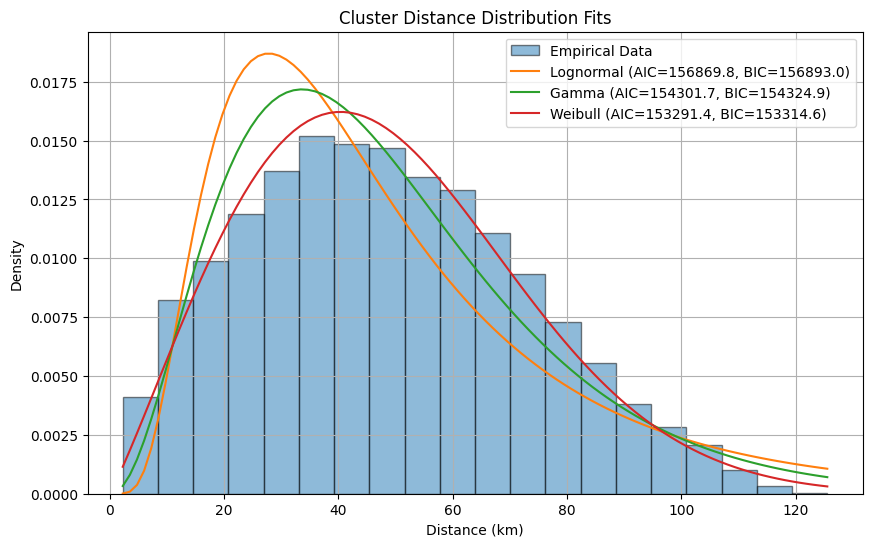

In [20]:
# ============================================
# STEP 6.2: Gravity Model Distance Distribution Fit
# - Loads cluster summary and centroid distance matrix from SQLite
# - Builds distance-population-business dataframe for cluster pairs
# - Fits Lognormal, Gamma, and Weibull distributions to distances
# - Computes AIC/BIC for each fit
# - Plots comparison of distributions and empirical data
# ============================================


# === 1. Define Utility Functions ===
def calculate_aic_bic(n, log_likelihood, num_params):
    aic = 2 * num_params - 2 * log_likelihood
    bic = num_params * log(n) - 2 * log_likelihood
    return aic, bic

# === 2. Connect to Database and Load Data ===
db_path = './database/BANTHE.db'

with sqlite3.connect(db_path) as conn:
    cluster_df = pd.read_sql_query("SELECT * FROM cluster_summary", conn)
    dist_df = pd.read_sql_query("SELECT * FROM centroid_distance_matrix", conn)

# === 3. Prepare and Filter Data ===
cluster_df['cluster'] = cluster_df['cluster'].astype(int)
dist_df.set_index('start_cluster_id', inplace=True)
dist_df.columns = dist_df.columns.astype(int)

valid_clusters = sorted(set(cluster_df['cluster']).intersection(set(dist_df.index)).intersection(set(dist_df.columns)))

# === 4. Build Pairwise DataFrame for Cluster Pairs ===
data_rows = []
for cA in valid_clusters:
    for cB in valid_clusters:
        if cA != cB:
            dist_km = dist_df.at[cA, cB]
            if pd.notna(dist_km) and dist_km > 0:
                data_rows.append({
                    'Cluster_A': cA,
                    'Cluster_B': cB,
                    'Distance_km': dist_km,
                    'total_population': cluster_df.loc[cluster_df['cluster'] == cA, 'total_population'].values[0],
                    'num_businesses': cluster_df.loc[cluster_df['cluster'] == cB, 'num_businesses'].values[0],
                    'total_boardings': cluster_df.loc[cluster_df['cluster'] == cA, 'total_boardings'].values[0],
                    'Flow': 1  # Placeholder
                })

data = pd.DataFrame(data_rows)
data['Distance_km'] += 1e-6  # Avoid divide-by-zero

# === 5. Fit Distributions and Calculate AIC/BIC ===
x = np.linspace(data['Distance_km'].min(), data['Distance_km'].max(), 100)
fit_results = {}

for name, dist in {'Lognormal': lognorm, 'Gamma': gamma, 'Weibull': weibull_min}.items():
    try:
        params = dist.fit(data['Distance_km'], floc=0)
        pdf = dist.pdf(x, *params)
        loglik = np.sum(dist.logpdf(data['Distance_km'], *params))
        aic, bic = calculate_aic_bic(len(data), loglik, len(params))

        fit_results[name] = {
            'params': params,
            'pdf': pdf,
            'AIC': aic,
            'BIC': bic
        }
    except Exception as e:
        print(f"⚠️ Error fitting {name}: {e}")

# === 6. Plot Distribution Fits ===
plt.figure(figsize=(10, 6))
plt.hist(data['Distance_km'], bins=20, density=True, alpha=0.5, edgecolor='black', label='Empirical Data')

for name, result in fit_results.items():
    plt.plot(x, result['pdf'], label=f"{name} (AIC={result['AIC']:.1f}, BIC={result['BIC']:.1f})")

plt.xlabel('Distance (km)')
plt.ylabel('Density')
plt.title('Cluster Distance Distribution Fits')
plt.legend()
plt.grid()
plt.show()


### 6.3 Normalize and Plot Weibull Distribution

✅ Normalized Weibull distribution saved to Output/6/normalized_weibull_distribution.csv


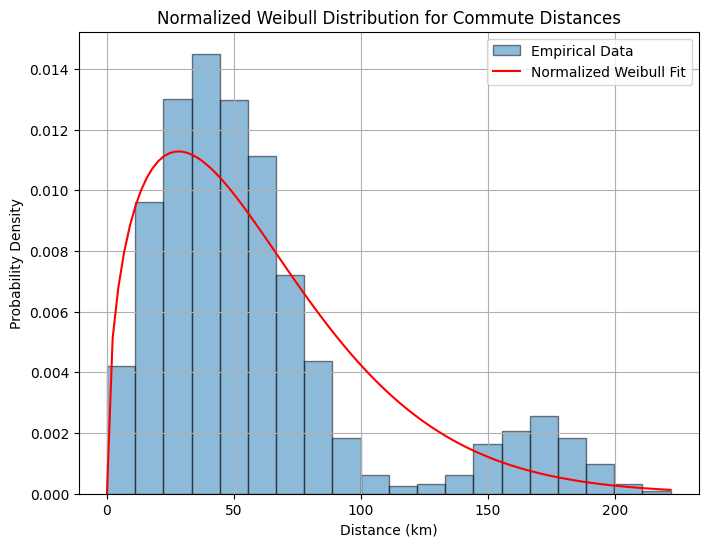

In [21]:
# ============================================
# STEP 6.3: Normalize and Plot Weibull Distribution
# - Loads gravity model calibration results from CSV
# - Fits Weibull distribution to distance data
# - Normalizes the Weibull PDF to match empirical data range
# - Saves normalized values to CSV
# - Plots comparison between data and fitted distribution
# ============================================

# === 1. Define Normalization Function ===
def normalize_distribution(data, dist, params):
    x = np.linspace(data['Distance_km'].min(), data['Distance_km'].max(), 100)
    pdf_values = dist.pdf(x, *params)
    normalization_factor = np.trapz(pdf_values, x)
    return x, pdf_values / normalization_factor

# === 2. Load Gravity Model Calibration Results ===
input_path = 'Output/6/gravity_model_calibrated_results.csv'
data = pd.read_csv(input_path)

# === 3. Fit Weibull Distribution ===
params_weibull = weibull_min.fit(data['Distance_km'], floc=0)

# === 4. Normalize Weibull Distribution ===
x, pdf_weibull_normalized = normalize_distribution(data, weibull_min, params_weibull)

# === 5. Save Normalized Values to CSV ===
output_path = 'Output/6/normalized_weibull_distribution.csv'
distribution_df = pd.DataFrame({'Distance_km': x, 'Normalized_Weibull': pdf_weibull_normalized})
distribution_df.to_csv(output_path, index=False)
print(f"✅ Normalized Weibull distribution saved to {output_path}")

# === 6. Plot Data vs Normalized Weibull ===
plt.figure(figsize=(8, 6))
plt.hist(data['Distance_km'], bins=20, edgecolor='black', density=True, alpha=0.5, label='Empirical Data')
plt.plot(x, pdf_weibull_normalized, 'r-', label='Normalized Weibull Fit')
plt.xlabel("Distance (km)")
plt.ylabel("Probability Density")
plt.title("Normalized Weibull Distribution for Commute Distances")
plt.legend()
plt.grid(True)
plt.show()


### 6.4 Travel Matrix Simulation using Weibull Distribution

In [22]:
# ============================================
# STEP 6.4: Travel Matrix Simulation using Weibull Distribution
# - Reads normalized Weibull distribution from CSV
# - Loads cluster boardings and distances from database
# - Simulates travel flows between clusters based on Weibull probabilities
# - Outputs travel matrix as CSV and database table
# - Generates matrix-formatted travel table for visualization
# ============================================

# === 1. Define Input/Output Paths ===
weibull_distribution_path = 'Output/6/normalized_weibull_distribution.csv'
cluster_summary_path = 'Output/6/cluster_summary.csv'
db_path = './database/BANTHE.db'
output_path = 'Output/6/travel_matrix.csv'
matrix_output_path = 'Output/6/travel_matrix_matrix.csv'

# === 2. Load Normalized Weibull Distribution ===
df_weibull = pd.read_csv(weibull_distribution_path)
df_weibull['Min_Distance'] = [0] + df_weibull['Distance_km'][:-1].tolist()
df_weibull['Max_Distance'] = df_weibull['Distance_km']
df_weibull = df_weibull[['Min_Distance', 'Max_Distance', 'Normalized_Weibull']]

# === 3. Load Cluster Boarding Data ===
df_clusters = pd.read_csv(cluster_summary_path)[['cluster', 'total_boardings']].rename(columns={
    'cluster': 'ClusterID',
    'total_boardings': 'TotalBoardings'
})

# === 4. Connect to SQLite Database and Load Distances ===
conn = sqlite3.connect(db_path)
df_distances = pd.read_sql_query("""
    SELECT start_cluster_id, end_cluster_id, total_distance_km
    FROM cluster_distances
""", conn)

# === 5. Define Travel Matrix Simulation Function ===
def calculate_travel_matrix_simulation():
    travel_matrix = []

    for start_cluster in df_clusters['ClusterID'].unique():
        start_boardings = df_clusters.loc[df_clusters['ClusterID'] == start_cluster, 'TotalBoardings'].values[0]
        destinations = df_distances[df_distances['start_cluster_id'] == start_cluster]

        # Calculate destination probabilities using Weibull
        total_probability = 0
        probabilities = []
        for _, row in destinations.iterrows():
            distance = row['total_distance_km']
            weibull_row = df_weibull[
                (df_weibull['Min_Distance'] <= distance) & (df_weibull['Max_Distance'] > distance)
            ]
            probability = weibull_row['Normalized_Weibull'].values[0] if not weibull_row.empty else 0
            probabilities.append(probability)
            total_probability += probability

        # Normalize probabilities
        if total_probability > 0:
            probabilities = [p / total_probability for p in probabilities]
        else:
            probabilities = [0] * len(destinations)

        # Initial passenger allocation
        initial_assignments = np.floor(np.array(probabilities) * start_boardings).astype(int)
        assigned_passengers = initial_assignments.sum()
        remainder = start_boardings - assigned_passengers

        # Distribute remaining passengers by probability
        sorted_indices = np.argsort(-np.array(probabilities))
        for idx in sorted_indices:
            if remainder == 0:
                break
            initial_assignments[idx] += 1
            remainder -= 1

        # Add to travel matrix
        for (index, row), passengers in zip(destinations.iterrows(), initial_assignments):
            travel_matrix.append((start_cluster, row['end_cluster_id'], passengers))

    return pd.DataFrame(travel_matrix, columns=['StartCluster', 'EndCluster', 'Passengers'])

# === 6. Run Simulation and Save Results ===
df_travel_matrix = calculate_travel_matrix_simulation()

# Save to database and CSV
df_travel_matrix.to_sql('travel_matrix', conn, if_exists='replace', index=False)
print(f"✅ Travel matrix saved to database.")

df_travel_matrix.to_csv(output_path, index=False)
print(f"✅ Travel matrix saved to CSV: {output_path}")

# === 7. Generate and Save Matrix Format ===
def create_matrix(df):
    matrix = df.pivot(index='StartCluster', columns='EndCluster', values='Passengers').fillna(0).astype(int)
    return matrix

travel_matrix_matrix = create_matrix(df_travel_matrix)
travel_matrix_matrix.to_csv(matrix_output_path)
print(f"✅ Travel matrix (matrix format) saved to CSV: {matrix_output_path}")

# Save matrix format to database
travel_matrix_matrix.reset_index().to_sql('travel_matrix_matrix', conn, if_exists='replace', index=False)
print(f"✅ Travel matrix (matrix format) saved to database.")

# === 8. Close Database Connection ===
conn.close()
print("✅ Database connection closed.")


✅ Travel matrix saved to database.
✅ Travel matrix saved to CSV: Output/6/travel_matrix.csv
✅ Travel matrix (matrix format) saved to CSV: Output/6/travel_matrix_matrix.csv
✅ Travel matrix (matrix format) saved to database.
✅ Database connection closed.


## Step 7: Define and Store Transport Emission Factors

In [23]:
# ============================================
# STEP 7: Define and Store Transport Emission Factors
# - Defines CO2-equivalent emission factor per kilometer for buses
# - Ensures the 'transport_emission' table exists in SQLite database
# - Deletes existing table if it exists to avoid duplicates
# - Creates new table with the updated emission factor value
# - Stores emission factor as a single value in the database
# ============================================

# === 1. Define Input Values and Database Path ===

database_path = "Database/BANTHE.db"

# CO2-equivalent emissions per kilometer for bus transport (kg CO2/km)
bus_emission_per_km_value = 1.08

# === 2. Connect to SQLite Database ===

conn = sqlite3.connect(database_path)
cursor = conn.cursor()

# === 3. Delete Existing 'transport_emission' Table if Exists ===

try:
    cursor.execute("DROP TABLE IF EXISTS transport_emission")
    print("Existing table 'transport_emission' dropped if it existed.")
except sqlite3.Error as e:
    print(f"Error while dropping table: {e}")
    conn.close()
    raise

# === 4. Create 'transport_emission' Table and Insert Emission Factor ===

try:
    cursor.execute("""
    CREATE TABLE transport_emission (
        bus_emission_per_km REAL
    )
    """)
    cursor.execute("INSERT INTO transport_emission (bus_emission_per_km) VALUES (?)", (bus_emission_per_km_value,))
    print("Table 'transport_emission' created and emission factor inserted.")
except sqlite3.Error as e:
    print(f"Error while creating table: {e}")
    conn.close()
    raise

# === 5. Commit Changes and Close Connection ===

conn.commit()
conn.close()

print("✅ Emission factor successfully stored in 'transport_emission'.")


Existing table 'transport_emission' dropped if it existed.
Table 'transport_emission' created and emission factor inserted.
✅ Emission factor successfully stored in 'transport_emission'.


## Step 8: Calculate Emissions for Bus Routes and Store in Database

In [24]:
# ============================================
# STEP 8: Calculate Emissions for Bus Routes and Store in Database
# - Retrieves dynamic average speed from existing cluster routes
# - Updates missing travel times in 'cluster_distances'
# - Loads emission factor from 'transport_emission' table
# - Ensures 'bus_routes_with_emission' table has required columns
# - Clears existing route records to avoid duplicates
# - Inserts new routes with calculated travel time and CO2 emissions
# ============================================

# === 1. Connect to SQLite Database ===
db_path = "Database/BANTHE.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# === 2. Calculate Dynamic Average Speed from cluster_distances ===
cursor.execute("""
SELECT 
    SUM(total_distance_km) AS total_distance,
    SUM(total_travel_time) AS total_time
FROM cluster_distances
WHERE total_travel_time IS NOT NULL
""")
result = cursor.fetchone()

if result and result[0] and result[1] and result[1] > 0:
    total_distance_km = result[0]
    total_time_hr = result[1]
    avg_speed_kmh = total_distance_km / total_time_hr
    print(f"✅ Dynamic average speed calculated: {avg_speed_kmh:.2f} km/h")
else:
    raise ValueError("❌ Could not calculate average speed: Missing or invalid data in cluster_distances")

# === 3. Update NULL travel times in cluster_distances using dynamic average speed ===
cursor.execute("""
UPDATE cluster_distances
SET total_travel_time = total_distance_km / ?
WHERE total_travel_time IS NULL
""", (avg_speed_kmh,))
conn.commit()
print("✅ Missing total_travel_time values updated in 'cluster_distances'.")

# === 4. Retrieve Bus Emission Factor ===
cursor.execute("SELECT bus_emission_per_km FROM transport_emission LIMIT 1;")
bus_emission = cursor.fetchone()
if not bus_emission:
    raise ValueError("❌ Emission factor missing in 'transport_emission' table.")
bus_emission_value = bus_emission[0]
print(f"✅ Bus emission factor retrieved: {bus_emission_value} kg CO2/km")

# === 5. Ensure 'total_travel_time' Column Exists in 'bus_routes_with_emission' ===
cursor.execute("PRAGMA table_info(bus_routes_with_emission);")
existing_columns = [col[1] for col in cursor.fetchall()]

if "total_travel_time" not in existing_columns:
    cursor.execute("ALTER TABLE bus_routes_with_emission ADD COLUMN total_travel_time REAL;")
    conn.commit()
    print("✅ Column 'total_travel_time' added to 'bus_routes_with_emission'.")

# === 6. Clear Existing Data in 'bus_routes_with_emission' ===
cursor.execute("DELETE FROM bus_routes_with_emission;")
conn.commit()
print("Existing data cleared from 'bus_routes_with_emission'.")

# === 7. Insert Entur-Based Routes with Emissions ===
cursor.execute("""
INSERT INTO bus_routes_with_emission (
    start_cluster_id, end_cluster_id,
    total_distance_km, total_travel_time,
    emission_kg, route_entur
)
SELECT
    cd.start_cluster_id, cd.end_cluster_id,
    cd.total_distance_km, cd.total_travel_time,
    cd.total_distance_km * ?,
    cd.route_entur
FROM cluster_distances cd
JOIN clusters c1 ON cd.start_cluster_id = c1.cluster_id
JOIN clusters c2 ON cd.end_cluster_id = c2.cluster_id
WHERE cd.route_entur IS NOT NULL
  AND c1.direct_roads_to_all_clusters = 0
  AND c2.direct_roads_to_all_clusters = 0
  AND cd.start_cluster_id != 77
  AND cd.end_cluster_id != 77
""", (bus_emission_value,))
conn.commit()
print("✅ Entur-based routes inserted with emissions into 'bus_routes_with_emission'.")

# === 8. Insert OSM-Based Routes with Emissions ===
cursor.execute("""
INSERT INTO bus_routes_with_emission (
    start_cluster_id, end_cluster_id,
    total_distance_km, total_travel_time,
    emission_kg, route
)
SELECT
    cd.start_cluster_id, cd.end_cluster_id,
    cd.total_distance_km, cd.total_travel_time,
    cd.total_distance_km * ?,
    cd.route
FROM cluster_distances cd
JOIN clusters c1 ON cd.start_cluster_id = c1.cluster_id
JOIN clusters c2 ON cd.end_cluster_id = c2.cluster_id
WHERE cd.route IS NOT NULL
  AND c1.direct_roads_to_all_clusters = 1
  AND c2.direct_roads_to_all_clusters = 1
""", (bus_emission_value,))
conn.commit()
print("✅ OSM-based routes inserted with emissions into 'bus_routes_with_emission'.")

# === 9. Finalize and Close Connection ===
conn.close()
print("✅ Finished: 'bus_routes_with_emission' updated with travel times and emissions.")


✅ Dynamic average speed calculated: 53.70 km/h
✅ Missing total_travel_time values updated in 'cluster_distances'.
✅ Bus emission factor retrieved: 1.08 kg CO2/km
Existing data cleared from 'bus_routes_with_emission'.
✅ Entur-based routes inserted with emissions into 'bus_routes_with_emission'.
✅ OSM-based routes inserted with emissions into 'bus_routes_with_emission'.
✅ Finished: 'bus_routes_with_emission' updated with travel times and emissions.


## Step 9: 

### 9.1: Estimate Bus Routes from Clusters to Quays

#### 9.1A: Mainland Clusters → Mainland Quays (A* Search with OSM Network)

In [25]:
# ============================================
# STEP 9.1A: Estimate Bus Routes from Mainland Clusters to Mainland Quays
# - Loads clusters with direct mainland road access
# - Loads mainland quay locations from database
# - Builds road network from GraphML file
# - Calculates shortest road routes using A* search algorithm
# - Estimates travel distance and time based on dynamic average speed
# - Stores results in 'cluster_to_quay_routes' table in SQLite database
# ============================================

# === 1. Configuration and Setup ===

db_path = 'Database/BANTHE.db'
graphml_path = 'vestlandet_bounded_road_network.graphml'

# === 2. Connect to SQLite Database ===

conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# === 3. Retrieve Dynamic Average Speed from cluster_distances ===

cursor.execute("""
SELECT 
    SUM(total_distance_km) AS total_distance,
    SUM(total_travel_time) AS total_time
FROM cluster_distances
WHERE total_travel_time IS NOT NULL
""")
result = cursor.fetchone()

if result and result[0] and result[1] and result[1] > 0:
    total_distance_km = result[0]
    total_time_hr = result[1]
    avg_speed_kmh = total_distance_km / total_time_hr
    print(f"✅ Dynamic average speed used for calculations: {avg_speed_kmh:.2f} km/h")
else:
    raise ValueError("❌ Could not calculate average speed: Missing or invalid data in cluster_distances")

# === 4. Create Destination Table for Cluster-Quay Routes ===

cursor.execute("DROP TABLE IF EXISTS cluster_to_quay_routes")
cursor.execute("""
CREATE TABLE cluster_to_quay_routes (
    bus_quay_route_id INTEGER PRIMARY KEY AUTOINCREMENT,
    start_cluster_id INTEGER,
    start_cluster_lat REAL,
    start_cluster_lon REAL,
    start_quay_id INTEGER,
    start_quay_lat REAL,
    start_quay_lon REAL,
    distance_km REAL,
    travel_time_hr REAL,
    route BLOB,
    route_entur BLOB
);
""")
conn.commit()
print("✅ Table 'cluster_to_quay_routes' created.")

# === 5. Load Cluster and Quay Data ===

clusters = pd.read_sql_query("""
SELECT cluster_id, latitude, longitude
FROM clusters
WHERE direct_roads_to_all_clusters = 1
""", conn)

quays = pd.read_sql_query("""
SELECT quay_id, latitude AS lat, longitude AS lon
FROM quays
WHERE is_on_island = 0
""", conn)

print(f"Loaded {len(clusters)} mainland clusters and {len(quays)} mainland quays.")

# === 6. Load Road Network Graph ===

graph = ox.load_graphml(graphml_path)

# === 7. Find Nearest Graph Nodes for Clusters and Quays ===

def nearest_node(lat, lon):
    return ox.distance.nearest_nodes(graph, X=lon, Y=lat)

clusters['nearest_node'] = clusters.apply(lambda row: nearest_node(row['latitude'], row['longitude']), axis=1)
quays['nearest_node'] = quays.apply(lambda row: nearest_node(row['lat'], row['lon']), axis=1)

# === 8. Calculate Routes using A* Search ===

def calculate_route(start_row, end_row):
    try:
        path = nx.astar_path(graph, start_row['nearest_node'], end_row['nearest_node'], weight="length")
        dist_km = nx.path_weight(graph, path, weight="length") / 1000
        time_hr = dist_km / avg_speed_kmh
        return {
            "start_cluster_id": start_row["cluster_id"],
            "start_cluster_lat": start_row["latitude"],
            "start_cluster_lon": start_row["longitude"],
            "start_quay_id": end_row["quay_id"],
            "start_quay_lat": end_row["lat"],
            "start_quay_lon": end_row["lon"],
            "distance_km": dist_km,
            "travel_time_hr": time_hr,
            "route": pickle.dumps(path),
            "route_entur": None
        }
    except nx.NetworkXNoPath:
        return None

# === 9. Parallel Route Calculation ===

results = []
start_time = time.time()
with ThreadPoolExecutor() as executor:
    futures = [
        executor.submit(calculate_route, c, q)
        for _, c in clusters.iterrows()
        for _, q in quays.iterrows()
    ]
    for i, future in enumerate(as_completed(futures), 1):
        result = future.result()
        if result:
            results.append(result)
        if i % 10 == 0:
            print(f"{i}/{len(futures)} routes calculated")

print(f"✅ Route calculation completed in {time.time() - start_time:.2f} seconds.")

# === 10. Store Results in Database ===

cursor.executemany("""
INSERT INTO cluster_to_quay_routes (
    start_cluster_id, start_cluster_lat, start_cluster_lon,
    start_quay_id, start_quay_lat, start_quay_lon,
    distance_km, travel_time_hr, route, route_entur
) VALUES (
    :start_cluster_id, :start_cluster_lat, :start_cluster_lon,
    :start_quay_id, :start_quay_lat, :start_quay_lon,
    :distance_km, :travel_time_hr, :route, :route_entur
)
""", results)
conn.commit()

print(f"✅ {len(results)} routes saved to 'cluster_to_quay_routes'.")

# === 11. Close Database Connection ===

conn.close()

✅ Dynamic average speed used for calculations: 53.70 km/h
✅ Table 'cluster_to_quay_routes' created.
Loaded 119 mainland clusters and 12 mainland quays.
10/1428 routes calculated
20/1428 routes calculated
30/1428 routes calculated
40/1428 routes calculated
50/1428 routes calculated
60/1428 routes calculated
70/1428 routes calculated
80/1428 routes calculated
90/1428 routes calculated
100/1428 routes calculated
110/1428 routes calculated
120/1428 routes calculated
130/1428 routes calculated
140/1428 routes calculated
150/1428 routes calculated
160/1428 routes calculated
170/1428 routes calculated
180/1428 routes calculated
190/1428 routes calculated
200/1428 routes calculated
210/1428 routes calculated
220/1428 routes calculated
230/1428 routes calculated
240/1428 routes calculated
250/1428 routes calculated
260/1428 routes calculated
270/1428 routes calculated
280/1428 routes calculated
290/1428 routes calculated
300/1428 routes calculated
310/1428 routes calculated
320/1428 routes calc

#### 9.1B: Island Clusters (except Cluster 77) → Quay 12 (Entur API)

In [26]:
# ============================================
# STEP 9.1B: Copy Entur Cluster-to-Quay Routes to cluster_to_quay_routes
# - Ensures 'travel_time_hr' column exists in target table
# - Deletes existing Entur routes for quay 12
# - Inserts new data with distance, Entur route and travel time
# - Updates coordinates for clusters and quays
# ============================================

# === 1. Connect to SQLite Database ===

db_path = "Database/BANTHE.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# === 2. Ensure travel_time_hr Column Exists ===

cursor.execute("PRAGMA table_info(cluster_to_quay_routes);")
columns = [col[1] for col in cursor.fetchall()]
if "travel_time_hr" not in columns:
    cursor.execute("ALTER TABLE cluster_to_quay_routes ADD COLUMN travel_time_hr REAL;")
    conn.commit()
    print("✅ Added 'travel_time_hr' column to 'cluster_to_quay_routes'.")

# === 3. Delete Existing Entur Routes for quay 12 ===

sql_delete = """
DELETE FROM cluster_to_quay_routes
WHERE route_entur IS NOT NULL AND start_quay_id = 12;
"""
cursor.execute(sql_delete)
conn.commit()
print("Deleted existing Entur routes for quay 12 from 'cluster_to_quay_routes'.")

# === 4. Insert New Entur Routes with Travel Time ===

sql_insert = """
INSERT INTO cluster_to_quay_routes (
    start_cluster_id, start_quay_id,
    distance_km, route_entur, travel_time_hr
)
SELECT 
    start_cluster_id, start_quay_id,
    distance_km_to_quay, route_entur_to_quay, travel_time_to_quay
FROM cluster_0_to_quay_12;
"""
cursor.execute(sql_insert)
conn.commit()
print("✅ Inserted new Entur routes with travel_time_hr from 'cluster_0_to_quay_12'.")

# === 5. Update start_cluster_lat and start_cluster_lon ===

sql_update_clusters = """
UPDATE cluster_to_quay_routes
SET start_cluster_lat = (
    SELECT latitude FROM clusters WHERE clusters.cluster_id = cluster_to_quay_routes.start_cluster_id
),
start_cluster_lon = (
    SELECT longitude FROM clusters WHERE clusters.cluster_id = cluster_to_quay_routes.start_cluster_id
)
WHERE start_cluster_id IS NOT NULL;
"""
cursor.execute(sql_update_clusters)
conn.commit()
print("✅ Updated start_cluster coordinates (lat/lon).")

# === 6. Update start_quay_lat and start_quay_lon ===

sql_update_quays = """
UPDATE cluster_to_quay_routes
SET start_quay_lat = (
    SELECT latitude FROM quays WHERE quays.Quay_id = cluster_to_quay_routes.start_quay_id
),
start_quay_lon = (
    SELECT longitude FROM quays WHERE quays.Quay_id = cluster_to_quay_routes.start_quay_id
)
WHERE start_quay_id IS NOT NULL;
"""
cursor.execute(sql_update_quays)
conn.commit()
print("✅ Updated start_quay coordinates (lat/lon).")

# === 7. Close Database Connection ===

conn.close()
print("✅ Done! All Entur routes for quay 12 copied and travel_time_hr updated.")


Deleted existing Entur routes for quay 12 from 'cluster_to_quay_routes'.
✅ Inserted new Entur routes with travel_time_hr from 'cluster_0_to_quay_12'.
✅ Updated start_cluster coordinates (lat/lon).
✅ Updated start_quay coordinates (lat/lon).
✅ Done! All Entur routes for quay 12 copied and travel_time_hr updated.


#### 9.1C: Island Cluster 77 → Quay 13 (Entur API)

In [27]:
# ============================================
# STEP 9.1C: Copy Cluster 77 Entur Route to cluster_to_quay_routes
# - Ensures 'travel_time_hr' column exists in target table
# - Deletes existing Entur routes for quay 13
# - Inserts new data from cluster_77_quay_13 with distance and travel time
# - Updates coordinates for clusters and quays
# ============================================

# === 1. Connect to SQLite Database ===

db_path = "Database/BANTHE.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# === 2. Ensure travel_time_hr Column Exists ===

cursor.execute("PRAGMA table_info(cluster_to_quay_routes);")
columns = [col[1] for col in cursor.fetchall()]
if "travel_time_hr" not in columns:
    cursor.execute("ALTER TABLE cluster_to_quay_routes ADD COLUMN travel_time_hr REAL;")
    conn.commit()
    print("✅ Added 'travel_time_hr' column to 'cluster_to_quay_routes'.")

# === 3. Delete Existing Entur Routes for quay 13 ===

sql_delete = """
DELETE FROM cluster_to_quay_routes
WHERE route_entur IS NOT NULL AND start_quay_id = 13;
"""
cursor.execute(sql_delete)
conn.commit()
print("Deleted existing Entur routes for quay 13 from 'cluster_to_quay_routes'.")

# === 4. Insert Route Data from cluster_77_quay_13 ===

sql_insert = """
INSERT INTO cluster_to_quay_routes (
    start_cluster_id, start_quay_id, distance_km, route_entur, travel_time_hr
)
SELECT 
    start_cluster_id, start_quay_id, distance_km_to_quay, route_entur_to_quay, travel_time_to_quay
FROM cluster_77_quay_13;
"""
cursor.execute(sql_insert)
conn.commit()
print("✅ Inserted route data from 'cluster_77_quay_13' to 'cluster_to_quay_routes'.")

# === 5. Update start_cluster_lat and start_cluster_lon ===

sql_update_clusters = """
UPDATE cluster_to_quay_routes
SET start_cluster_lat = (
    SELECT latitude FROM clusters WHERE clusters.cluster_id = cluster_to_quay_routes.start_cluster_id
),
start_cluster_lon = (
    SELECT longitude FROM clusters WHERE clusters.cluster_id = cluster_to_quay_routes.start_cluster_id
)
WHERE start_cluster_id IS NOT NULL;
"""
cursor.execute(sql_update_clusters)
conn.commit()
print("✅ Updated start_cluster coordinates (lat/lon).")

# === 6. Update start_quay_lat and start_quay_lon ===

sql_update_quays = """
UPDATE cluster_to_quay_routes
SET start_quay_lat = (
    SELECT latitude FROM quays WHERE quays.Quay_id = cluster_to_quay_routes.start_quay_id
),
start_quay_lon = (
    SELECT longitude FROM quays WHERE quays.Quay_id = cluster_to_quay_routes.start_quay_id
)
WHERE start_quay_id IS NOT NULL;
"""
cursor.execute(sql_update_quays)
conn.commit()
print("✅ Updated start_quay coordinates (lat/lon).")

# === 7. Close Database Connection ===

conn.close()
print("✅ Done! Cluster 77 route to quay 13 updated in 'cluster_to_quay_routes'.")


Deleted existing Entur routes for quay 13 from 'cluster_to_quay_routes'.
✅ Inserted route data from 'cluster_77_quay_13' to 'cluster_to_quay_routes'.
✅ Updated start_cluster coordinates (lat/lon).
✅ Updated start_quay coordinates (lat/lon).
✅ Done! Cluster 77 route to quay 13 updated in 'cluster_to_quay_routes'.


### 9.2 Make all possible combinations for busroutes and potential boat-routes

In [28]:
# ============================================
# STEP 9.2: Generate Cluster-to-Quay Combinations 
# - Loads clusters, quays, and attributes from database
# - Applies custom rules for:
#   - Cluster 77 special cases
#   - Quay 12 / Quay 13 interactions
#   - Mainland and Huftarøy cluster relations
# - Mirrors combinations to ensure bi-directionality
# - Saves results in 'cluster_to_quay_combinations' table in SQLite database
# ============================================

# === 1. Connect to SQLite Database ===

db_path = 'Database/BANTHE.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# === 2. Load Unique Cluster and Quay IDs ===

cursor.execute("SELECT DISTINCT start_cluster_id FROM cluster_to_quay_routes")
cluster_ids = {row[0] for row in cursor.fetchall()}

cursor.execute("SELECT DISTINCT start_quay_id FROM cluster_to_quay_routes")
quay_ids = {row[0] for row in cursor.fetchall()}

# === 3. Load Cluster Attributes (direct_roads_to_all_clusters) ===

cursor.execute("SELECT cluster_id, direct_roads_to_all_clusters FROM clusters")
clusters_data = {row[0]: row[1] for row in cursor.fetchall()}

# === 4. Load Island Quays (is_on_island = 1) ===

cursor.execute("SELECT Quay_id FROM quays WHERE is_on_island = 1")
island_quays = {row[0] for row in cursor.fetchall()}

# === 5. Define Special IDs and Cluster Groups ===

quay_12 = 12
quay_13 = 13
cluster_77 = 77

direct_roads_0_clusters = {c for c, v in clusters_data.items() if v == 0 and c != cluster_77}
mainland_clusters = {c for c in cluster_ids if c not in direct_roads_0_clusters and c != cluster_77}

# === 6. Generate Combinations Based on Rules ===

combinations = []

# Step 1: Cluster 77 → Quay 13 → All quays except 13
for end_quay in quay_ids - {quay_13}:
    valid_end_clusters = (
        direct_roads_0_clusters if end_quay == quay_12 else mainland_clusters | direct_roads_0_clusters
    )
    for end_cluster in valid_end_clusters:
        combinations.append((cluster_77, quay_13, end_quay, end_cluster))

# Step 2: Cluster 77 → Quay 13 → Quay 12 → Direct_roads=0 clusters (excluding 77)
for end_cluster in direct_roads_0_clusters:
    combinations.append((cluster_77, quay_13, quay_12, end_cluster))

# Step 3: Huftarøy Clusters → Quay 12 → All quays
for start_cluster in direct_roads_0_clusters:
    for end_quay in quay_ids - {quay_12}:
        valid_end_clusters = {cluster_77} if end_quay == quay_13 else mainland_clusters | direct_roads_0_clusters
        for end_cluster in valid_end_clusters:
            combinations.append((start_cluster, quay_12, end_quay, end_cluster))

# Step 4: Mainland Clusters → Quays (not 12/13) → All quays
for start_cluster in mainland_clusters:
    for start_quay in quay_ids - {quay_12, quay_13}:
        for end_quay in quay_ids - {start_quay}:
            valid_end_clusters = (
                direct_roads_0_clusters if end_quay == quay_12 else
                {cluster_77} if end_quay == quay_13 else
                mainland_clusters | direct_roads_0_clusters
            )
            for end_cluster in valid_end_clusters:
                combinations.append((start_cluster, start_quay, end_quay, end_cluster))

# === 7. Mirror Combinations (bi-directionality) ===

mirrored_combinations = [(e, eq, sq, s) for s, sq, eq, e in combinations]
combinations.extend(mirrored_combinations)

# === 8. Save Combinations to Database ===

combinations_df = pd.DataFrame(
    combinations,
    columns=["start_cluster_id", "start_quay_id", "end_quay_id", "end_cluster_id"]
)

cursor.execute("""
CREATE TABLE IF NOT EXISTS cluster_to_quay_combinations (
    combination_id INTEGER PRIMARY KEY AUTOINCREMENT,
    start_cluster_id INTEGER,
    start_quay_id INTEGER,
    end_quay_id INTEGER,
    end_cluster_id INTEGER
)
""")

cursor.execute("DELETE FROM cluster_to_quay_combinations")
conn.commit()

cursor.executemany("""
INSERT INTO cluster_to_quay_combinations (
    start_cluster_id, start_quay_id, end_quay_id, end_cluster_id
) VALUES (?, ?, ?, ?)
""", combinations_df.values.tolist())

conn.commit()
conn.close()

print(f"✅ Total {len(combinations_df)} combinations generated and saved.")


✅ Total 4118196 combinations generated and saved.


### 9.3 Populate Cluster-to-Quay Combinations with Emission Data

In [29]:
# ============================================
# STEP 9.3: Populate Cluster-to-Quay Combinations with Emission Data
# - Creates 'cluster_to_quay_combinations_with_emission' table
# - Calculates emissions for bus routes from clusters to quays
# - Joins start and end bus routes with quay boat distances
# - Computes emissions based on distance and emission factor
# - Saves results including distances, travel times, and emissions
# ============================================

# === 1. Connect to SQLite Database ===

db_path = "Database/BANTHE.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# === 2. Drop and Recreate Target Table ===

table_name = "cluster_to_quay_combinations_with_emission"
cursor.execute(f"DROP TABLE IF EXISTS {table_name}")

cursor.execute(f"""
    CREATE TABLE {table_name} (
        combination_id INTEGER PRIMARY KEY AUTOINCREMENT,
        start_cluster_id INTEGER,
        start_quay_id INTEGER,
        start_distance_km REAL,
        travel_time_hr_start REAL,
        start_route_id INTEGER,
        end_quay_id INTEGER,
        end_cluster_id INTEGER,
        end_distance_km REAL,
        travel_time_hr_end REAL,
        end_route_id INTEGER,
        boat_distance_km REAL,
        travel_time_boat REAL,
        emission_start REAL,
        emission_end REAL,
        emission_total REAL
    )
""")

# === 3. Retrieve Emission Factor ===

emission_row = cursor.execute("SELECT bus_emission_per_km FROM transport_emission").fetchone()
if not emission_row:
    print("❌ Missing 'bus_emission_per_km' value in 'transport_emission'")
    conn.close()
    exit(1)
emission_per_km = emission_row[0]


# === 4. Join Data for Start and End Routes ===

query = """
SELECT 
    ctc.combination_id,
    ctc.start_cluster_id,
    ctc.start_quay_id,
    sr.distance_km AS start_distance_km,
    sr.travel_time_hr AS travel_time_hr_start,
    sr.bus_quay_route_id AS start_route_id,
    ctc.end_quay_id,
    ctc.end_cluster_id,
    er.distance_km AS end_distance_km,
    er.travel_time_hr AS travel_time_hr_end,
    er.bus_quay_route_id AS end_route_id,
    qd.boat_distance_km,
    qd.boat_travel_time_hr AS travel_time_boat
FROM cluster_to_quay_combinations ctc
LEFT JOIN cluster_to_quay_routes sr
    ON sr.start_cluster_id = ctc.start_cluster_id AND sr.start_quay_id = ctc.start_quay_id
LEFT JOIN cluster_to_quay_routes er
    ON er.start_cluster_id = ctc.end_cluster_id AND er.start_quay_id = ctc.end_quay_id
LEFT JOIN quay_distances qd
    ON qd.start_quay_id = ctc.start_quay_id AND qd.end_quay_id = ctc.end_quay_id
"""

rows = cursor.execute(query).fetchall()

# === 5. Calculate Emissions and Build Result Rows ===

enriched_rows = []
for row in rows:
    (
        _, start_cluster_id, start_quay_id, start_distance_km, travel_time_hr_start, start_route_id,
        end_quay_id, end_cluster_id, end_distance_km, travel_time_hr_end, end_route_id,
        boat_distance_km, travel_time_boat
    ) = row

    emission_start = (start_distance_km or 0) * emission_per_km
    emission_end = (end_distance_km or 0) * emission_per_km
    emission_total = emission_start + emission_end

    enriched_rows.append((
        start_cluster_id, start_quay_id, start_distance_km, travel_time_hr_start,
        start_route_id, end_quay_id, end_cluster_id, end_distance_km, travel_time_hr_end,
        end_route_id, boat_distance_km, travel_time_boat,
        emission_start, emission_end, emission_total
    ))

# === 6. Insert Computed Rows into Table ===

cursor.executemany(f"""
    INSERT INTO {table_name} (
        start_cluster_id, start_quay_id, start_distance_km, travel_time_hr_start,
        start_route_id, end_quay_id, end_cluster_id, end_distance_km, travel_time_hr_end,
        end_route_id, boat_distance_km, travel_time_boat,
        emission_start, emission_end, emission_total
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
""", enriched_rows)

conn.commit()
conn.close()

print(f"✅ Table '{table_name}' populated with {len(enriched_rows)} records.")


✅ Table 'cluster_to_quay_combinations_with_emission' populated with 4118196 records.


## Step 10. Create Final Dataset for Optimization

### 10.1 Make final dataset for the optimization

In [30]:
# ============================================
# STEP 10.1: Create Final Dataset for Optimization
# - Creates table 'final_data_for_optimization' with all relevant routing and emission data
# - Inserts combination routes (bus-boat-bus) with travel time and emissions
# - Inserts direct bus routes for all cluster pairs
# - Calculates number of trips needed based on travel demand
# - Updates emissions and travel time for optimization purposes
# ============================================

# === 1. Connect to SQLite Database ===

db_path = 'Database/BANTHE.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

try:
    # === 2. Drop and Recreate Output Table ===
    cursor.execute("DROP TABLE IF EXISTS final_data_for_optimization")
    cursor.execute("""
    CREATE TABLE final_data_for_optimization (
        combination_id INTEGER,
        start_cluster_id INTEGER,
        end_cluster_id INTEGER,
        start_quay_id INTEGER,
        start_route_id INTEGER,
        start_distance_km REAL,
        end_quay_id INTEGER,
        end_route_id INTEGER,
        end_distance_km REAL,
        boat_distance_km REAL,
        emission_start REAL,
        emission_end REAL,
        emission_total_one_trip REAL,
        emission_total REAL,
        travel_time_hr_start REAL,
        travel_time_hr_end REAL,
        boat_travel_time_hr REAL,
        total_travel_time REAL,
        only_bus_route BLOB,
        only_bus_distance REAL,
        only_bus_emission REAL,
        only_bus_time REAL,
        trips_needed INTEGER,
        total_emission_bus REAL,
        total_num_passengers INTEGER
    )
    """)
    print("✅ Table 'final_data_for_optimization' created.")

    # === 3. Insert Combination Routes (Bus-boat-Bus) ===
    cursor.execute("""
    INSERT INTO final_data_for_optimization (
        combination_id, start_cluster_id, end_cluster_id,
        start_quay_id, start_route_id, start_distance_km,
        end_quay_id, end_route_id, end_distance_km,
        boat_distance_km,
        emission_start, emission_end, emission_total_one_trip,
        travel_time_hr_start, travel_time_hr_end, boat_travel_time_hr,
        total_travel_time
    )
    SELECT 
        combination_id, start_cluster_id, end_cluster_id,
        start_quay_id, start_route_id, start_distance_km,
        end_quay_id, end_route_id, end_distance_km,
        boat_distance_km,
        emission_start, emission_end, emission_total,
        travel_time_hr_start, travel_time_hr_end, travel_time_boat,
        IFNULL(travel_time_hr_start, 0) + IFNULL(travel_time_boat, 0) + IFNULL(travel_time_hr_end, 0)
    FROM cluster_to_quay_combinations_with_emission
    WHERE emission_total <= (
        SELECT MAX(emission_kg) FROM bus_routes_with_emission
    )
    """)
    print("✅ Combination routes inserted.")

    # === 4. Insert Direct Bus Routes ===
    cursor.execute("""
    INSERT INTO final_data_for_optimization (
        start_cluster_id, end_cluster_id,
        only_bus_route, only_bus_distance, only_bus_emission, only_bus_time
    )
    SELECT 
        start_cluster_id, end_cluster_id,
        route, total_distance_km, emission_kg, total_travel_time
    FROM bus_routes_with_emission
    """)
    print("✅ Direct bus routes inserted.")

    # === 5. Update Passenger-Based Calculations ===
    df = pd.read_sql_query("""
    SELECT rowid, start_cluster_id, end_cluster_id, only_bus_emission, only_bus_time
    FROM final_data_for_optimization
    WHERE only_bus_emission IS NOT NULL
    """, conn)

    travel_df = pd.read_sql_query("SELECT * FROM travel_matrix", conn)

    avg_capacity = (79 + 62) / 2
    fill_rate = 0.5
    effective_capacity = avg_capacity * fill_rate

    updates = []
    for _, row in df.iterrows():
        start = row['start_cluster_id']
        end = row['end_cluster_id']
        rowid = row['rowid']
        emission_one = row['only_bus_emission']
        bus_time = row['only_bus_time']

        match = travel_df[
            (travel_df['StartCluster'] == start) &
            (travel_df['EndCluster'] == end)
        ]

        if not match.empty:
            passengers = match.iloc[0]['Passengers']
            trips = int(passengers / effective_capacity + 0.9999)
            total_emission = emission_one * trips
            updates.append((trips, total_emission, passengers, total_emission, bus_time, rowid))
        else:
            updates.append((None, None, None, None, bus_time, rowid))

    # === 6. Update Table with Calculated Values ===
    cursor.executemany("""
    UPDATE final_data_for_optimization
    SET 
        trips_needed = ?, 
        total_emission_bus = ?, 
        total_num_passengers = ?, 
        emission_total = ?, 
        total_travel_time = ?
    WHERE rowid = ?
    """, updates)

    conn.commit()
    print(f"✅ Updated {len(updates)} rows with passenger data.")

except Exception as e:
    print(f"❌ Error: {e}")

finally:
    conn.close()
    print("Database connection closed.")


✅ Table 'final_data_for_optimization' created.
✅ Combination routes inserted.
✅ Direct bus routes inserted.
✅ Updated 14132 rows with passenger data.
Database connection closed.


### 10.2 Clean Up Cluster-to-Quay Restrictions

In [31]:
# ============================================
# STEP 10.2: Clean Up Cluster-to-Quay Restrictions
# - Removes invalid combinations from final_data_for_optimization
# - Ensures:
#     - Cluster 77 can only use quay 13
#     - Selected clusters can only use quay 12
# ============================================

# === 1. Define Database Path and Quay Restrictions ===

db_path = "Database/BANTHE.db"
quay_12_clusters = (48, 81, 21, 83, 55, 34, 97, 127, 7, 101)

# === 2. Clean Restrictions Function ===

def clean_quay_restrictions():
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    try:
        # === 3. Remove invalid combinations for Cluster 77 (must use quay 13) ===
        cursor.execute("""
            DELETE FROM final_data_for_optimization
            WHERE (start_cluster_id = 77 AND start_quay_id IS NOT NULL AND start_quay_id != 13)
               OR (end_cluster_id = 77 AND end_quay_id IS NOT NULL AND end_quay_id != 13)
        """)
        print("✅ Removed invalid quay assignments for Cluster 77.")

        # === 4. Remove invalid combinations for quay_12_clusters (must use quay 12) ===
        cursor.execute(f"""
            DELETE FROM final_data_for_optimization
            WHERE (start_cluster_id IN {quay_12_clusters} AND start_quay_id IS NOT NULL AND start_quay_id != 12)
               OR (end_cluster_id IN {quay_12_clusters} AND end_quay_id IS NOT NULL AND end_quay_id != 12)
        """)
        print(f"✅ Removed invalid quay assignments for clusters restricted to quay 12: {quay_12_clusters}")

        # === 5. Commit Changes ===
        conn.commit()

    except Exception as e:
        print(f"❌ Error during cleaning: {e}")

    finally:
        conn.close()
        print("Database connection closed.")

# === 6. Execute the Cleaning Function ===

clean_quay_restrictions()


✅ Removed invalid quay assignments for Cluster 77.
✅ Removed invalid quay assignments for clusters restricted to quay 12: (48, 81, 21, 83, 55, 34, 97, 127, 7, 101)
Database connection closed.


### 10.3  Update Total Emissions for Bus and Combination Routes

In [32]:
# ============================================
# STEP 10: Update Total Emissions for Bus and Combination Routes
# - Loads passenger demand from travel_matrix
# - Calculates number of trips required based on capacity and fill rate
# - Updates total emissions and passenger counts for:
#     1. Direct bus routes
#     2. Bus-boat-Bus combination routes
# - Saves results into 'final_data_for_optimization'
# ============================================

# === 1. Connect to SQLite Database ===

db_path = "Database/BANTHE.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# === 2. Load Travel Demand Matrix ===

travel_df = pd.read_sql_query("SELECT StartCluster, EndCluster, Passengers FROM travel_matrix", conn)

# === 3. Define Effective Bus Capacity ===

avg_capacity = (79 + 62) / 2
fill_rate = 0.5
effective_capacity = avg_capacity * fill_rate

# === 4. Update Direct Bus Routes ===

df_bus = pd.read_sql_query("""
    SELECT rowid, start_cluster_id, end_cluster_id, only_bus_emission
    FROM final_data_for_optimization
    WHERE only_bus_emission IS NOT NULL
""", conn)

updates_bus = []
for _, row in tqdm(df_bus.iterrows(), total=len(df_bus), desc="🚍 Processing Direct Bus Routes"):
    match = travel_df[
        (travel_df['StartCluster'] == row['start_cluster_id']) &
        (travel_df['EndCluster'] == row['end_cluster_id'])
    ]
    if not match.empty:
        passengers = match.iloc[0]['Passengers']
        trips = ceil(passengers / effective_capacity)
        total_emission = row['only_bus_emission'] * trips
        updates_bus.append((trips, total_emission, passengers, row['rowid']))
    else:
        updates_bus.append((None, None, None, row['rowid']))

cursor.executemany("""
    UPDATE final_data_for_optimization
    SET trips_needed = ?, total_emission_bus = ?, total_num_passengers = ?
    WHERE rowid = ?
""", updates_bus)

# === 5. Update Combination Routes (Bus-boat-Bus) ===

df_combo = pd.read_sql_query("""
    SELECT rowid, start_cluster_id, end_cluster_id, emission_total_one_trip
    FROM final_data_for_optimization
    WHERE emission_total_one_trip IS NOT NULL
""", conn)

updates_combo = []
for _, row in tqdm(df_combo.iterrows(), total=len(df_combo), desc="⛴ Processing Combination Routes"):
    match = travel_df[
        (travel_df['StartCluster'] == row['start_cluster_id']) &
        (travel_df['EndCluster'] == row['end_cluster_id'])
    ]
    if not match.empty:
        passengers = match.iloc[0]['Passengers']
        trips = ceil(passengers / effective_capacity)
        total_emission = row['emission_total_one_trip'] * trips
        updates_combo.append((trips, total_emission, passengers, row['rowid']))
    else:
        updates_combo.append((None, None, None, row['rowid']))

cursor.executemany("""
    UPDATE final_data_for_optimization
    SET trips_needed = ?, emission_total = ?, total_num_passengers = ?
    WHERE rowid = ?
""", updates_combo)

# === 6. Finalize Updates ===

conn.commit()
conn.close()

print(f"✅ Successfully updated emissions and passenger data for both bus and combination routes.")


⛴ Processing Combination Routes:  54%|█████▍    | 1757385/3260960 [04:37<03:50, 6526.79it/s]

### 10.4 Evaluate optimized routes against bus times

In [ ]:
# ============================================
# Step 10.4: Generate and Evaluate Filtered Optimization Tables
# - Creates 5 datasets with varying time thresholds (0, 100%, 120%, 140%, 150% of bus time)
# - Retains island cluster routes even if threshold exceeded
# - Evaluates how many routes are valid vs. excluded in each dataset
# ============================================

import sqlite3
import pandas as pd

# === 1. Connect to SQLite database ===
db_path = "Database/BANTHE.db"
conn = sqlite3.connect(db_path)

# === 2. Define island clusters (always keep) ===
island_clusters = {48, 81, 21, 83, 55, 34, 97, 127, 7, 101, 77}

# === 3. Load base optimization data and bus reference data ===
opt_df = pd.read_sql_query("SELECT * FROM final_data_for_optimization", conn)
bus_df = pd.read_sql_query("""
    SELECT start_cluster_id, end_cluster_id, total_travel_time AS bus_time
    FROM bus_routes_with_emission
""", conn)

# === 4. Merge datasets and compute thresholds ===
merged = opt_df.merge(bus_df, on=["start_cluster_id", "end_cluster_id"], how="left")
merged["bus_time_100"] = merged["bus_time"] * 1.0
merged["bus_time_120"] = merged["bus_time"] * 1.2
merged["bus_time_140"] = merged["bus_time"] * 1.4
merged["bus_time_150"] = merged["bus_time"] * 1.5

# === 5. Define time thresholds and table names ===
time_limits = [0, 1.0, 1.2, 1.4, 1.5]
table_names = [
    "final_data_for_optimization_0",
    "final_data_for_optimization_100",
    "final_data_for_optimization_120",
    "final_data_for_optimization_140",
    "final_data_for_optimization_150"
]

# === 6. Generate and evaluate each filtered dataset ===
for limit, table in zip(time_limits, table_names):
    if limit == 0:
        result_df = opt_df.copy()
    else:
        col = f"bus_time_{int(limit * 100)}"
        merged["keep"] = (
            (merged["total_travel_time"] <= merged[col]) |
            (merged["start_cluster_id"].isin(island_clusters)) |
            (merged["end_cluster_id"].isin(island_clusters))
        )
        result_df = merged[merged["keep"]].drop(columns=[
            "bus_time", "bus_time_100", "bus_time_120", "bus_time_140", "bus_time_150", "keep"
        ])

    # Store filtered dataset in new table
    result_df.to_sql(table, conn, if_exists="replace", index=False)

    # === 7. Evaluate result ===
    merged_eval = result_df.merge(bus_df, on=["start_cluster_id", "end_cluster_id"], how="inner")

    if limit == 0:
        valid_count = len(merged_eval)
        excluded_count = 0
    else:
        threshold_time = merged_eval["bus_time"] * limit
        merged_eval["keep"] = (
            (merged_eval["total_travel_time"] <= threshold_time) |
            (merged_eval["start_cluster_id"].isin(island_clusters)) |
            (merged_eval["end_cluster_id"].isin(island_clusters))
        )
        valid_count = merged_eval["keep"].sum()
        excluded_count = len(merged_eval) - valid_count

    # === 8. Print evaluation summary ===
    print(f"\nTable: {table}")
    print(f"✅ Valid routes: {valid_count:,}")
    print(f"❌ Excluded routes: {excluded_count:,}")
    print(f"Total evaluated: {len(merged_eval):,}")

# === 9. Close connection ===
conn.close()



Table: final_data_for_optimization_0
✅ Valid routes: 3,186,444
❌ Excluded routes: 0
Total evaluated: 3,186,444

Table: final_data_for_optimization_100
✅ Valid routes: 15,656
❌ Excluded routes: 0
Total evaluated: 15,656

Table: final_data_for_optimization_120
✅ Valid routes: 46,528
❌ Excluded routes: 0
Total evaluated: 46,528

Table: final_data_for_optimization_140
✅ Valid routes: 136,916
❌ Excluded routes: 0
Total evaluated: 136,916

Table: final_data_for_optimization_150
✅ Valid routes: 177,712
❌ Excluded routes: 0
Total evaluated: 177,712


## Step 11: Optimize Routes with different time constraints

In [ ]:
# ============================================
# STEP 11: Optimize Routes (All Time Threshold Variants)
# - Iterates over 5 filtered datasets with different time constraints
# - Loads route and emission data from each dataset
# - Builds optimization model minimizing total emissions
# - Ensures one valid route per cluster pair
# - Stores optimized routes in 'optimized_routes_X' (e.g. 0, 100, 120, 140, 150)
# ============================================

import sqlite3
import pandas as pd
from itertools import product
import pulp

# === Configuration ===
db_path = 'Database/BANTHE.db'

def optimize_routes():
    conn = sqlite3.connect(db_path)

    # === 1. Load Reference Travel Times (Bus) ===
    ref_bus = pd.read_sql_query("""
        SELECT start_cluster_id, end_cluster_id, total_travel_time
        FROM bus_routes_with_emission
    """, conn)

    # === 2. Define Dataset Versions to Process ===
    time_suffixes = ["0", "100", "120", "140", "150"]

    for suffix in time_suffixes:
        input_table = f"final_data_for_optimization_{suffix}"
        output_table = f"optimized_routes_{suffix}"

        print(f"\nOptimizing datasets!: {input_table}")

        # === 3. Load Filtered Route Dataset ===
        try:
            final_df = pd.read_sql_query(f"SELECT * FROM {input_table}", conn)
        except Exception as e:
            print(f"❌ Failed to load {input_table}: {e}")
            continue

        # === 4. Validate Emission Column ===
        if 'emission_total' not in final_df.columns:
            print(f"❌ Column 'emission_total' missing in {input_table}. Skipping.")
            continue

        final_df = final_df[final_df['emission_total'].notnull()]
        final_df['total_emission'] = final_df['emission_total']

        # === 5. Compute Total Travel Time for Each Route ===
        final_df['total_time'] = final_df['travel_time_hr_start'].fillna(0) + \
                                 final_df['boat_travel_time_hr'].fillna(0) + \
                                 final_df['travel_time_hr_end'].fillna(0)

        # === 6. Merge with Bus Reference Times ===
        df = final_df.merge(ref_bus, on=['start_cluster_id', 'end_cluster_id'], how='left', suffixes=('', '_bus'))

        # === 7. Generate All Cluster Pairs ===
        clusters = sorted(set(df['start_cluster_id']).union(df['end_cluster_id']))
        all_combos = pd.DataFrame(product(clusters, clusters), columns=['start_cluster_id', 'end_cluster_id'])
        all_combos = all_combos[all_combos['start_cluster_id'] != all_combos['end_cluster_id']]

        # === 8. Merge to Ensure All Cluster Pairs Have Options ===
        full_df = all_combos.merge(df, on=['start_cluster_id', 'end_cluster_id'], how='left')
        placeholder_emission = 1e6
        full_df['total_emission'].fillna(placeholder_emission, inplace=True)

        # === 9. Define Optimization Problem ===
        prob = pulp.LpProblem("Minimize_Total_Emissions", pulp.LpMinimize)
        x = pulp.LpVariable.dicts("x", full_df.index, cat='Binary')
        prob += pulp.lpSum(full_df.loc[i, 'total_emission'] * x[i] for i in full_df.index)

        # === 10. Constraints: One Valid Route per Cluster Pair ===
        for (s, e), group in full_df.groupby(['start_cluster_id', 'end_cluster_id']):
            prob += pulp.lpSum(x[i] for i in group.index) == 1, f"OneRoute_{s}_{e}"

        # === 11. Solve Optimization ===
        prob.solve()

        # === 12. Extract Selected Routes ===
        selected = [full_df.loc[i] for i in full_df.index if pulp.value(x[i]) == 1]
        result_df = pd.DataFrame(selected)

        # === 13. Store Optimized Routes ===
        if not result_df.empty:
            result_df.to_sql(output_table, conn, if_exists="replace", index=False)
            print(f"✅ Optimization complete. Stored in {output_table}: {len(result_df)} routes")
        else:
            print(f"❌ No feasible routes found for {input_table}.")

    conn.close()

# === Run Optimization Over All Variants ===
optimize_routes()



Optimizing datasets!: final_data_for_optimization_0


/var/folders/z2/yf_08gvs05z_lw82fjkb6ps80000gn/T/ipykernel_28357/2469597516.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_df['total_emission'].fillna(placeholder_emission, inplace=True)


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sondres.b.siger/myenv/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/z2/yf_08gvs05z_lw82fjkb6ps80000gn/T/4f2b6068407e4c9e808b3ea3aed65886-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/z2/yf_08gvs05z_lw82fjkb6ps80000gn/T/4f2b6068407e4c9e808b3ea3aed65886-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 16775 COLUMNS
At line 13008546 RHS
At line 13025317 BOUNDS
At line 16273982 ENDATA
Problem MODEL has 16770 rows, 3248664 columns and 3248664 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2.52952e+07 - 0.59 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 2.52952e+07 to -1.79769e+308
Probing w

/var/folders/z2/yf_08gvs05z_lw82fjkb6ps80000gn/T/ipykernel_28357/2469597516.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_df['total_emission'].fillna(placeholder_emission, inplace=True)


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sondres.b.siger/myenv/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/z2/yf_08gvs05z_lw82fjkb6ps80000gn/T/2f44361104be40ccb97ac070f47e9696-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/z2/yf_08gvs05z_lw82fjkb6ps80000gn/T/2f44361104be40ccb97ac070f47e9696-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 16775 COLUMNS
At line 325394 RHS
At line 342165 BOUNDS
At line 420042 ENDATA
Problem MODEL has 16770 rows, 77876 columns and 77876 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 4.25242e+07 - 0.02 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 4.25242e+07 to -1.79769e+308
Probing was tried 0

/var/folders/z2/yf_08gvs05z_lw82fjkb6ps80000gn/T/ipykernel_28357/2469597516.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_df['total_emission'].fillna(placeholder_emission, inplace=True)


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sondres.b.siger/myenv/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/z2/yf_08gvs05z_lw82fjkb6ps80000gn/T/5b4fa613157746969d6fb2d0d966d76e-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/z2/yf_08gvs05z_lw82fjkb6ps80000gn/T/5b4fa613157746969d6fb2d0d966d76e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 16775 COLUMNS
At line 448882 RHS
At line 465653 BOUNDS
At line 574402 ENDATA
Problem MODEL has 16770 rows, 108748 columns and 108748 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 4.00574e+07 - 0.03 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 4.00574e+07 to -1.79769e+308
Probing was tried

/var/folders/z2/yf_08gvs05z_lw82fjkb6ps80000gn/T/ipykernel_28357/2469597516.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_df['total_emission'].fillna(placeholder_emission, inplace=True)


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sondres.b.siger/myenv/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/z2/yf_08gvs05z_lw82fjkb6ps80000gn/T/332c242d1e8145eeb5a93a16c5391dc6-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/z2/yf_08gvs05z_lw82fjkb6ps80000gn/T/332c242d1e8145eeb5a93a16c5391dc6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 16775 COLUMNS
At line 810434 RHS
At line 827205 BOUNDS
At line 1026342 ENDATA
Problem MODEL has 16770 rows, 199136 columns and 199136 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 3.52452e+07 - 0.05 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 3.52452e+07 to -1.79769e+308
Probing was trie

/var/folders/z2/yf_08gvs05z_lw82fjkb6ps80000gn/T/ipykernel_28357/2469597516.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_df['total_emission'].fillna(placeholder_emission, inplace=True)


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sondres.b.siger/myenv/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/z2/yf_08gvs05z_lw82fjkb6ps80000gn/T/acf00391e7b54fb6987aa3a40a58922b-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/z2/yf_08gvs05z_lw82fjkb6ps80000gn/T/acf00391e7b54fb6987aa3a40a58922b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 16775 COLUMNS
At line 973618 RHS
At line 990389 BOUNDS
At line 1230322 ENDATA
Problem MODEL has 16770 rows, 239932 columns and 239932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 3.31623e+07 - 0.06 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 3.31623e+07 to -1.79769e+308
Probing was trie

## Step 12: Generate Baseline Emissions from Cluster-to-Cluster Bus Routes

In [ ]:
# ============================================
# STEP 12: Generate Baseline Emissions from Cluster-to-Cluster Bus Routes
# - Clones 'cluster_distances' table into 'baseline_routes'
# - Calculates land-based distance (bus only: total_distance - boat_distance if boat used)
# - Applies bus emission factor to compute emissions per trip
# - Estimates number of trips based on travel_matrix and effective capacity
# - Computes total emissions for all trips
# - Updates 'baseline_routes' with:
#     - total_bus_distance_km
#     - total_emission_one_trip
#     - trips_needed
#     - total_emission_all_trips
# ============================================

def safe_float(val):
    try:
        return float(val)
    except (TypeError, ValueError):
        return 0.0

# === 1. Connect to SQLite database ===
db_path = "Database/BANTHE.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# === 2. Clone 'cluster_distances' to 'baseline_routes' ===
cursor.execute("DROP TABLE IF EXISTS baseline_routes;")
cursor.execute("CREATE TABLE baseline_routes AS SELECT * FROM cluster_distances;")
conn.commit()
print("✅ Created table 'baseline_routes' from 'cluster_distances'.")

# === 3. Load necessary data ===
df = pd.read_sql_query("SELECT * FROM baseline_routes", conn)
emission_row = pd.read_sql_query("SELECT * FROM transport_emission LIMIT 1", conn).iloc[0]
bus_emission_per_km = float(emission_row["bus_emission_per_km"])
travel_df = pd.read_sql_query("SELECT StartCluster, EndCluster, Passengers FROM travel_matrix", conn)

# === 4. Define effective bus capacity ===
avg_capacity = (79 + 62) / 2
fill_rate = 0.5
effective_capacity = avg_capacity * fill_rate

# === 5. Compute and prepare updates ===
updates = []
affected_clusters = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="🚌 Processing baseline routes"):
    start = row["start_cluster_id"]
    end = row["end_cluster_id"]
    total_distance = safe_float(row["total_distance_km"])
    boat_distance = safe_float(row.get("boat_distance_km", 0))  # fallback if column missing
    boat_time = safe_float(row["travel_time_boat"])

    # Calculate land-based bus distance
    if boat_time > 0:
        total_bus_distance_km = total_distance - boat_distance
        affected_clusters.append((start, end))
    else:
        total_bus_distance_km = total_distance

    emission_one_trip = total_bus_distance_km * bus_emission_per_km

    # Match with travel demand
    match = travel_df[
        (travel_df["StartCluster"] == start) &
        (travel_df["EndCluster"] == end)
    ]
    if not match.empty:
        passengers = match.iloc[0]["Passengers"]
        trips_needed = ceil(passengers / effective_capacity)
        emission_all_trips = trips_needed * emission_one_trip
    else:
        trips_needed = None
        emission_all_trips = None

    updates.append((
        total_bus_distance_km,
        emission_one_trip,
        trips_needed,
        emission_all_trips,
        start,
        end
    ))

# === 6. Add new columns if not exist ===
for col_name, col_type in [
    ("total_bus_distance_km", "REAL"),
    ("total_emission_one_trip", "REAL"),
    ("trips_needed", "INTEGER"),
    ("total_emission_all_trips", "REAL")
]:
    try:
        cursor.execute(f"ALTER TABLE baseline_routes ADD COLUMN {col_name} {col_type};")
    except sqlite3.OperationalError:
        pass  # Already exists

# === 7. Update table ===
cursor.executemany("""
    UPDATE baseline_routes
    SET total_bus_distance_km = ?,
        total_emission_one_trip = ?,
        trips_needed = ?,
        total_emission_all_trips = ?
    WHERE start_cluster_id = ? AND end_cluster_id = ?
""", updates)

conn.commit()
conn.close()


print("✅ Finished updating 'baseline_routes' with corrected baseline emissions.")


✅ Created table 'baseline_routes' from 'cluster_distances'.


🚌 Processing baseline routes: 100%|██████████| 16770/16770 [00:02<00:00, 6002.70it/s]


✅ Finished updating 'baseline_routes' with corrected baseline emissions.


## Step 13: Results 

### 13.1 Compare total CO₂ emissions across route variants

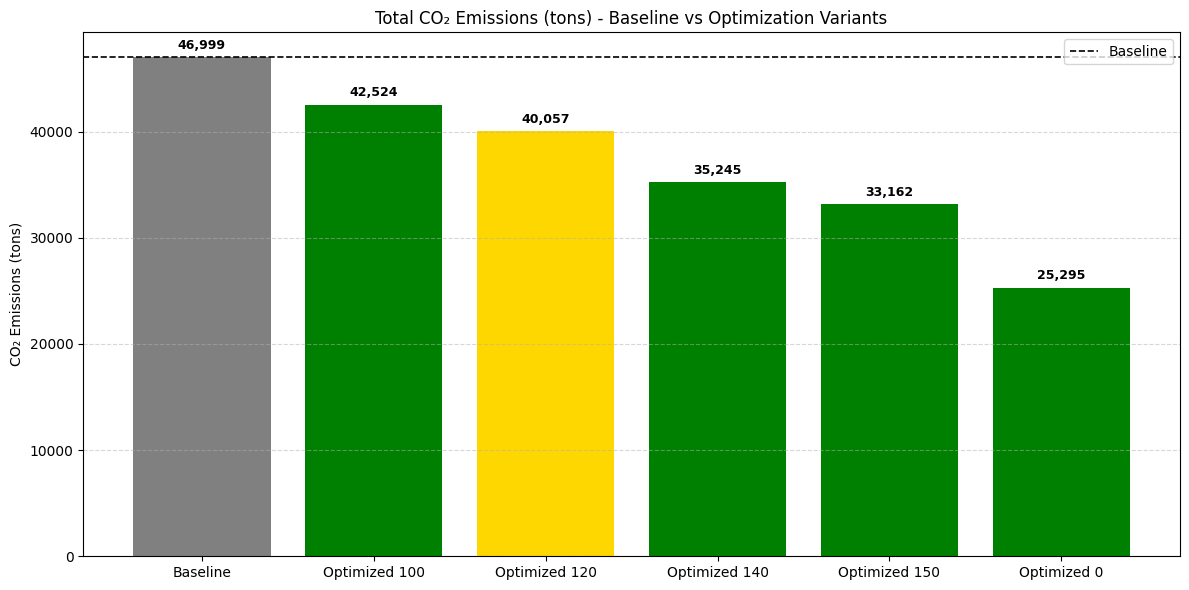

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# ============================================
# STEP 13.1: Compare total CO₂ emissions across route variants
# - Load baseline emissions (bus only)
# - Load emissions from each optimized route variant
# - Plot emissions in tons, highlighting key scenarios
# ============================================

# === 1. Connect to SQLite database ===
db_path = "Database/BANTHE.db"
conn = sqlite3.connect(db_path)

# === 2. Load baseline total emissions from original bus routes ===
baseline_df = pd.read_sql_query("""
    SELECT total_emission_all_trips
    FROM baseline_routes
    WHERE total_emission_all_trips IS NOT NULL
""", conn)
baseline_emission = baseline_df["total_emission_all_trips"].sum()

# === 3. Load total emissions from each optimized route variant ===
# Variant '0' represents the full dataset (no time constraints)
variant_order = ["100", "120", "140", "150", "0"]
emissions = []
for variant in variant_order:
    df = pd.read_sql_query(f"""
        SELECT total_emission
        FROM optimized_routes_{variant}
        WHERE total_emission IS NOT NULL
    """, conn)
    emissions.append(df["total_emission"].sum())

# === 4. Close the database connection ===
conn.close()

# === 5. Prepare data for visualization ===
labels = ["Baseline"] + [f"Optimized {v}" for v in variant_order]
values_kg = [baseline_emission] + emissions
values_ton = [v / 1000 for v in values_kg]  # Convert from kilograms to metric tons

# === 6. Assign colors to each bar (highlight Optimized 120 in gold) ===
colors = []
for label in labels:
    if label == "Baseline":
        colors.append("gray")
    elif label == "Optimized 120":
        colors.append("gold")
    else:
        colors.append("green")

# === 7. Create bar plot ===
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, values_ton, color=colors)

# === 8. Annotate each bar with the emission value ===
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 500,
        f"{height:,.0f}",
        ha='center',
        va='bottom',
        fontsize=9,
        weight='bold'
    )

# === 9. Add a reference line for the baseline emission ===
plt.axhline(values_ton[0], linestyle='--', color='black', linewidth=1.2, label='Baseline')

# === 10. Final plot formatting and display ===
plt.title("Total CO₂ Emissions (tons) - Baseline vs Optimization Variants")
plt.ylabel("CO₂ Emissions (tons)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


### 13.2 boat Visualization with Styled Legend and Scenario Labels

In [ ]:
# ============================================
# STEP 13.2: Final boat Visualization with Styled Legend and Scenario Labels
# - Adds fixed coords for quay 1 & 2 (Bergen)
# - Custom intuitive passenger intervals
# - Styled legend with dynamic route count and scenario label
# - File names mapped to readable % scenarios
# ============================================

# === 1. Connect to database ===
conn = sqlite3.connect("Database/BANTHE.db")

# === 2. Identify valid scenario tables ===
all_tables_df = pd.read_sql_query("""
    SELECT name FROM sqlite_master 
    WHERE type='table' AND name LIKE 'optimized_routes%';
""", conn)

excluded = {
    "optimized_routes_limited_quays",
    "optimized_routes_no_quay_limit",
    "optimized_routes_no_quay_limit_2"
}
valid_tables = [t for t in all_tables_df['name'] if t not in excluded]

# === 3. Define custom thresholds ===
thresholds = [0, 50_000, 500_000, 1_000_000, 1_500_000, 2_500_000, 3_000_000, float("inf")]
labels = [
    '0–49 999',
    '50 000–499 999',
    '500 000–999 999',
    '1 000 000–1 499 999',
    '1 500 000–2 499 999',
    '2 500 000–2 999 999',
    '3 000 000+'
]

# === 4. Load quay metadata ===
quays = pd.read_sql_query("SELECT quay_id, quay_name, latitude, longitude FROM quays", conn)
quays["quay_id"] = quays["quay_id"].astype(int)

# === 5. Insert manual coordinates for quay 1 and 2 (near Bergen) ===
manual_quays = pd.DataFrame([
    {
        "quay_id": 1,
        "quay_name": "Quay 1",
        "latitude": 60.41008910248214,
        "longitude": 5.320818028317846
    },
    {
        "quay_id": 2,
        "quay_name": "Quay 2",
        "latitude": 60.38987655368882,
        "longitude": 5.293143210116751
    }
])
quays = quays[~quays["quay_id"].isin([1, 2])]
quays = pd.concat([quays, manual_quays], ignore_index=True)

# === 6. Aggregate boat usage per scenario ===
quay_usage_all = {}
scenario_route_counts = {}

for table in valid_tables:
    df = pd.read_sql_query(f"""
        SELECT start_quay_id, end_quay_id, boat_distance_km, total_num_passengers
        FROM {table}
        WHERE boat_distance_km > 0 AND total_num_passengers > 0
    """, conn)

    quay_ids = pd.concat([
        df[["start_quay_id", "total_num_passengers"]].rename(columns={"start_quay_id": "quay_id"}),
        df[["end_quay_id", "total_num_passengers"]].rename(columns={"end_quay_id": "quay_id"})
    ])
    usage = quay_ids.groupby("quay_id")["total_num_passengers"].sum().reset_index()
    usage.columns = ["quay_id", table]
    quay_usage_all[table] = usage

    # count routes for this scenario
    scenario_route_counts[table] = len(df)

# === 7. Merge usage data into master dataframe ===
usage_merged = quays.copy()
for table, df in quay_usage_all.items():
    usage_merged = usage_merged.merge(df, on="quay_id", how="left")

# === 8. Compute average passenger volume ===
scenario_cols = list(quay_usage_all.keys())
usage_merged["average"] = usage_merged[scenario_cols].mean(axis=1)

# === 9. Assign usage bins ===
usage_merged["usage_group"] = pd.cut(
    usage_merged["average"].fillna(0),
    bins=thresholds,
    labels=labels,
    include_lowest=True,
    right=False
)

# === 10. Color palette ===
colors = ['lightblue', 'blue', 'green', 'orange', 'red', 'darkred', 'purple']
color_map = {label: colors[i] for i, label in enumerate(labels)}

# === 11. Mapping of table names to readable labels ===
scenario_name_map = {
    "optimized_routes_0": "No time constraint",
    "optimized_routes_100": "Strict 1",
    "optimized_routes_120": "120%",
    "optimized_routes_140": "140%",
    "optimized_routes_150": "150%",
}


# === 12. Create map per scenario and average ===
for col in scenario_cols + ["average"]:
    m = folium.Map(location=[60.4, 5.3], zoom_start=9, tiles="CartoDB positron")

    for _, row in usage_merged.iterrows():
        val = row[col]
        if pd.isna(val):
            continue
        group = pd.cut([val], bins=thresholds, labels=labels, include_lowest=True, right=False)[0]
        color = color_map.get(str(group), "gray")
        label = row["quay_id"]
        folium.Marker(
            location=[row["latitude"], row["longitude"]],
            icon=folium.DivIcon(html=f"""
                <div style="
                    font-size: 14px; color: white; background-color: {color};
                    border-radius: 50%; width: 30px; height: 30px; text-align: center;
                    line-height: 30px; border: 2px solid black;">
                    {label}
                </div>"""),
            popup=folium.Popup(
                f"<b>{row['quay_name']}</b><br>ID: {label}<br>"
                f"Passengers: {int(val):,}",
                max_width=250
            )
        ).add_to(m)

    # === 13. Add styled legend with scenario name and route count ===
    scenario_label = scenario_name_map.get(col, col)
    route_count = scenario_route_counts.get(col, sum(scenario_route_counts.values()) // len(scenario_route_counts))

    legend_html = "".join([
        f'<div style="margin-bottom: 4px;"><span style="color:{color_map[label]}; font-size:16px;">⬤</span> {label} passengers</div>'
        for label in labels
    ])
    legend = f"""
    <div style='position: fixed; bottom: 30px; left: 30px; width: 330px;
                background-color: white; border:2px solid #555; border-radius: 8px;
                z-index:9999; font-size:15px; line-height:1.5; padding: 14px;
                box-shadow: 0px 0px 10px rgba(0,0,0,0.25);'>
        <div style="font-size:18px; font-weight:bold; margin-bottom:6px;">
            Passenger Volume Distribution
        </div>
        <div style="font-size:13px; font-weight:bold; margin-bottom:4px;">
            Scenario: {scenario_label}
        </div>
        <div style="font-size:13px; font-style:italic; margin-bottom:10px;">
            Based on {route_count} boat routes evaluated
        </div>
        {legend_html}
    </div>
    """
    m.get_root().html.add_child(folium.Element(legend))

    # === 14. Save map with readable name ===
    m.save(f"quay_usage_map_{scenario_label}.html")
    print(f"✅ Saved map: quay_usage_map_{scenario_label}.html")

# === 15. Save CSV output ===
usage_merged.to_csv("quay_usage_by_scenario.csv", index=False)
print("✅ Saved CSV: quay_usage_by_scenario.csv")

conn.close()


✅ Saved map: quay_usage_map_optimized_routes.html
✅ Saved map: quay_usage_map_No time constraint.html
✅ Saved map: quay_usage_map_Strict 1.html
✅ Saved map: quay_usage_map_120%.html
✅ Saved map: quay_usage_map_140%.html
✅ Saved map: quay_usage_map_150%.html
✅ Saved map: quay_usage_map_average.html
✅ Saved CSV: quay_usage_by_scenario.csv


/var/folders/z2/yf_08gvs05z_lw82fjkb6ps80000gn/T/ipykernel_28357/838349043.py:92: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  usage_merged["average"].fillna(0),


### 13.3 Passenger Delay Summary Table by Scenario

In [ ]:
# ============================================
# STEP 13.3: Passenger Delay Summary Table by Scenario
# - Compares total travel time against bus-only travel time
# - Categorizes routes by how much slower (or faster) they are than bus
# - Aggregates passenger volumes per delay category
# - Outputs a summary PNG table comparing all scenarios
# ============================================

# === 1. Connect to SQLite and fetch valid optimization tables ===
conn = sqlite3.connect("Database/BANTHE.db")
tables = pd.read_sql_query("""
    SELECT name FROM sqlite_master 
    WHERE type='table' AND name LIKE 'optimized_routes_%';
""", conn)

# Exclude special-case tables
excluded = {
    "optimized_routes_limited_quays",
    "optimized_routes_no_quay_limit_2"
}
valid_tables = [t for t in tables["name"] if t not in excluded]

summary_frames = []

# === 2. Load and process route data for each scenario ===
for table in valid_tables:
    df = pd.read_sql_query(f"""
        SELECT start_cluster_id, end_cluster_id,
               total_travel_time, total_travel_time_bus, total_num_passengers
        FROM {table}
        WHERE total_travel_time IS NOT NULL AND total_travel_time_bus IS NOT NULL
    """, conn)

    # === 3. Calculate time difference and categorize delays ===
    df["time_diff_hr"] = df["total_travel_time"] - df["total_travel_time_bus"]
    df["time_diff_pct"] = (df["time_diff_hr"] / df["total_travel_time_bus"]) * 100

    # Define delay categories (binned by % difference)
    bins = [-float("inf"), -1e-6, 1e-6, 5, 10, 20, float("inf")]
    labels = [
        "Faster than bus",
        "Same as bus",
        "+1–5% slower",
        "+5–10% slower",
        "+10–20% slower",
        "Over +20% slower"
    ]
    df["delay_category"] = pd.cut(df["time_diff_pct"], bins=bins, labels=labels)

    # === 4. Sum passengers by delay category ===
    passenger_stats = (
        df.groupby("delay_category")["total_num_passengers"]
        .sum().reindex(labels).fillna(0).astype(int)
    )

    # === 5. Add scenario label ===
    scenario_name = table.replace("optimized_routes_", "")
    if scenario_name == "100":
        label = "Strict 1"
    elif scenario_name == "0":
        label = "No time constraint"
    elif scenario_name.isdigit():
        label = f"{scenario_name}%"
    else:
        label = scenario_name.title()

    # Store summary frame for this scenario
    summary_frames.append(pd.DataFrame({
        "Delay Category": labels,
        label: passenger_stats.values
    }))

# === 6. Merge all scenario summaries into a single DataFrame ===
df_all = summary_frames[0]
for df in summary_frames[1:]:
    df_all = df_all.merge(df, on="Delay Category")

conn.close()

# === 7. Create and export PNG table ===
fig, ax = plt.subplots(figsize=(14, 5))
ax.axis('off')

# Create table using matplotlib's table functionality
table = ax.table(
    cellText=df_all.drop(columns=["Delay Category"]).values,
    rowLabels=df_all["Delay Category"],
    colLabels=df_all.columns[1:],
    cellLoc='center',
    loc='center'
)

# Styling
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.4)

# Add title and save image
plt.title("Passenger Delay Summary by Scenario", fontsize=14, weight='bold', pad=20)
plt.tight_layout()
plt.savefig("passenger_delay_summary_by_scenario.png", dpi=300)
plt.close()

print("✅ Saved 'passenger_delay_summary_by_scenario.png'")



/var/folders/z2/yf_08gvs05z_lw82fjkb6ps80000gn/T/ipykernel_28357/1409909106.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("delay_category")["total_num_passengers"]
/var/folders/z2/yf_08gvs05z_lw82fjkb6ps80000gn/T/ipykernel_28357/1409909106.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("delay_category")["total_num_passengers"]
/var/folders/z2/yf_08gvs05z_lw82fjkb6ps80000gn/T/ipykernel_28357/1409909106.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or o

✅ Saved 'passenger_delay_summary_by_scenario.png'
